In [143]:
!pip install -U numpy==1.26.4 catboost shap optuna --quiet

# План домашних заданий


- Описание задачи и знакомство с данными
- Домашнее задание 1. Генерация и фильтрация признаков
- Домашнее задание 2. Прогноз времени и вида поломки машин, настройка ML-модели
- Домашнее задание 3. Оптимизация. Тюнинг гиперпараметров с помощью `Optuna`
- Домашнее задание 4. Блендинг
- Отправка финального решения на лидерборд на Kaggle
- Домашнее задание 5. Парсинг внешних данных и оптимизация памяти


In [144]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import catboost
import shap
import optuna

# <center id="part0"> Описание задачи

**Предыстория:**  мы работаем с каршеринговой компанией, которая управляет крупным автопарком машин. Наша цель — предотвратить длительные периоды простоя машин из-за поломок через своевременное обслуживание и ремонт.


**Идея для решения проблемы:** создать приоритизированный список обхода машин. Этот список поможет технической бригаде сосредоточиться на автомобилях, которые наиболее вероятно выйдут из строя в ближайшее время.


**Как компания решает задачу:**

* Собирает данные о поездках и состоянии машин до поломок.

* Нанимает Data Scientist, чтобы он смог использовать эти данные для анализа и прогнозирования характера поломок.

**Важный момент**: задачи этого специалиста (Data Scientist) предстоит выполнять вам.

## <center> Знакомство с данными

### Информация про машины с таргетом (основной датасет)

In [145]:
car_train = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/car_train.csv')
car_train.sample(5)

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class
1886,W-1602334H,Smart Coupe,economy,petrol,4.64,2015,88230,2020,32.97,engine_fuel
1052,k-2063559v,Kia Rio X,economy,petrol,6.30,2014,68270,2019,50.96,engine_check
686,r-7396117p,Smart Coupe,economy,petrol,5.60,2017,121467,2016,84.20,another_bug
2126,u24432042k,Kia Rio X-line,economy,petrol,3.06,2013,41027,2020,26.58,break_bug
1211,z-1435869q,Hyundai Solaris,economy,petrol,4.08,2014,57648,2018,63.14,engine_ignition


- `car_id` — идентификатор машины
- `model` / `car_type` / `fuel_type` — марка, класс и тип топлива машины
- `car_rating` / `riders` — общий рейтинг и общее число поездок к концу 2021 года
- `year_to_start` / `year_to_work` — год выпуска машины и год начала работы в автопарке
- `target_reg` — количество дней до поломки
- `target_class` — класс поломки (всего 9 видов)

### Информация про поездки

In [146]:
rides_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/rides_info.csv')
rides_info.sample(5)

,user_id,car_id,ride_id,ride_date,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,distance,refueling,user_ride_quality,deviation_normal
114754,t97368556l,I-2073229s,t1e,2020-02-16,0.10,14,162,28,50.000000,1,97.460825,0,-11.137322,-0.340
522858,H16217319g,k56274815U,N1g,2020-03-27,7.57,47,558,57,86.407024,0,2640.393650,0,4.548500,-6.398
302179,b25477929Z,V-3922506p,I1t,2020-03-02,7.09,55,545,40,50.400000,1,1849.523126,0,2.023876,-4.690
594489,l11925894q,q-1501864D,A1H,2020-02-25,3.27,78,931,46,71.000000,4,908.857529,0,3.941400,-13.221
700422,n15554380P,x-3347185z,z1v,2020-02-08,2.56,40,634,47,56.000000,1,1222.193912,0,NaN,-33.977


- `user_id` / `car_id` / `ride_id` — идентификаторы водителя, машины, поездки соответственно
- `ride_date` / `rating` — дата поездки и рейтинг, поставленный водителем
- `ride_duration` / `distance` / `ride_cost` —  длительность (время),  пройденное расстояние, стоимость поездки
- `speed_avg` / `speed_max` — средняя и максимальная скорости поездки соответственно
- `stop_times` / `refueling` — количество остановок (паузы) и флаг: была ли дозаправка
- `user_ride_quality` — оценка манеры вождения водителя машины, определенная скоринговой ML-системой сервиса
- `deviation_normal` — общий показатель датчиков о состоянии машины, относительно эталонных показателей (нормы)

### Информация про водителей

In [147]:
driver_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/driver_info.csv')
driver_info.sample(5)

,age,user_rating,user_rides,user_time_accident,user_id,sex,first_ride_date
11757,42,7.5,1090,6.0,t10790732A,0,2019-1-30
7564,34,7.9,753,63.0,Q22113350Y,0,2019-4-28
1290,31,6.1,1104,3.0,J18197951o,1,2020-11-28
6852,34,8.9,1691,6.0,R21087943r,0,2021-7-27
9812,18,8.1,1673,12.0,o85581706A,1,2018-6-5


- `user_id` / `age` / `sex` — идентификатор, возраст и пол водителя, соответственно
- `user_rating` — общий рейтинг пользователя за все поездки к концу 2021 года
- `user_rides` — общее количество поездок к концу 2021 года
- `user_time_accident` — число инцидентов (это могли быть аварии/штрафы/эвакуация машины)  
- `first_ride_date` — дата первой поездки

### Информация про ремонт машин

In [148]:
fix_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/fix_info.csv')
fix_info.sample(5)

,car_id,worker_id,fix_date,work_type,destroy_degree,work_duration
10414,Z95207161f,UD,2019-6-18 10:3,reparking,1.0,31
34166,z-1790906x,QO,2020-10-20 21:43,repair,5.0,21
9619,A-2110919g,HK,2019-6-14 23:0,refuel_check,1.0,22
4431,N18957837j,FZ,2020-1-30 14:22,reparking,1.0,35
121233,k81607148Q,OH,2019-1-22 0:0,reparking,8.0,48


- `worker_id` / `car_id` — идентификатор работника и машины
- `work_type` / `work_duration` — тип и длительность (в часах) проводимой работы
- `destroy_degree` — степень износа/поврежденности машины в случае поломки
- `fix_date` — время начала ремонта (снятия машины с линии)

# Домашнее задание 1. Генерация и фильтрация признаков

<center> <img src="https://ucarecdn.com/bf4c772d-b67a-42ae-a48b-cfd83910b0a2/" width=700>

<div class="alert alert-info">

**Цель блока** — сгенерировать признаки из дополнительных датасетов и добавить их к основному датасету, произвести фильтрацию признаков.

    
## 1. Генерация признаков из дополнительных датасетов (6 баллов)

<div class="alert alert-info">

1. Возьмите датасет `rides_info` с информацией о поездках и проведите группировку по каждой машине отдельно.

2. Для каждой машины (то есть для каждого `car_id`) подсчитайте несколько признаков:
  - минимальный рейтинг за все поездки;
  - средний рейтинг за все поездки;
  - общее количество километров, которое машина проехала;
  - максимальная скорость;
  - общее количество поездок для каждой машины.

3. Добавьте минимум 3 признака на свой выбор.

4. Сделайте соединение таблиц — вспомните про методы соединения и выберите подходящий для этого случая.

5. Подключите информацию про водителей (`driver_info`) и про ремонт машин (`fix_info`). Добавьте минимум 3 любых признака с каждого датасета.

6. **ОБЯЗАТЕЛЬНО!** Проверьте, что кол-во строк в полученном датафрейме равно изначальному кол-ву строк в исходном датасете car_train. Убедитесь, что нет дублей. (За это будут снижать баллы)


<h4> Критерии оценивания </h4>
    
- Добавлены 5 обязательных и минимум 3 любых признака из датасета `rides_info` — 2 балла.
- Добавлены минимум 3 любых признака из датасета `driver_info` — 2 балла.
- Добавлены минимум 3 любых признака из датасета `fix_info` — 2 балла.

</div>

<div class="alert alert-success">
    
<h4> Советы по Feature Engineering</h4>
    
- Начинайте с сырых данных.
- Используйте все доступные данные. Покрывайте признаками всю имеющуюся информацию в данных.
- Формулируйте предположения: от чего зависит таргет?
- Смотрите визуально на классы/ошибки и делайте предположения. Какие полезны?
- Помните, что слишком много признаков может быть вредно. Потом придется отфильтровывать.
    
<h4> Полезные источники </h4>
    
- Занятие про Feature Engineering.
- Занятие про Feature Selection.
- [Max Kuhn and Kjell Johnson. Feature Engineering and Selection: A Practical Approach for Predictive Models](http://www.feat.engineering/).

### Пример расчета признака

In [149]:
# Базовая агрегация по car_id
rides_agg = rides_info.groupby('car_id').agg(
    min_rating=('rating', 'min'),
    mean_rating=('rating', 'mean'),
    total_distance=('distance', 'sum'),
    max_speed=('speed_max', 'max'),
    total_rides=('ride_id', 'count')
).reset_index()

rides_agg.head()

,car_id,min_rating,mean_rating,total_distance,max_speed,total_rides
0,A-1049127W,0.1,4.255172,1.125753e+07,179.729652,174
1,A-1079539w,0.1,4.088046,1.912765e+07,184.505566,174
2,A-1162143G,0.1,4.662299,2.995194e+06,180.000000,174
3,A-1228282M,0.1,4.225172,1.793685e+07,182.446070,174
4,A-1339912r,0.1,4.690115,1.202552e+07,152.000000,174


In [150]:
# Группировка по car_id и расчёт обязательных признаков
rides_agg = rides_info.groupby('car_id').agg(
    min_rating=('rating', 'min'),             # минимальный рейтинг
    mean_rating=('rating', 'mean'),           # средний рейтинг
    total_distance=('distance', 'sum'),       # суммарная дистанция
    max_speed=('speed_max', 'max'),           # максимальная скорость
    total_rides=('ride_id', 'count')          # количество поездок
).reset_index()

rides_agg.head()

,car_id,min_rating,mean_rating,total_distance,max_speed,total_rides
0,A-1049127W,0.1,4.255172,1.125753e+07,179.729652,174
1,A-1079539w,0.1,4.088046,1.912765e+07,184.505566,174
2,A-1162143G,0.1,4.662299,2.995194e+06,180.000000,174
3,A-1228282M,0.1,4.225172,1.793685e+07,182.446070,174
4,A-1339912r,0.1,4.690115,1.202552e+07,152.000000,174


In [151]:
# Соединение car_train и rides_agg по car_id
car_train_merged = car_train.merge(rides_agg, on='car_id', how='left')

# Проверка
print(f'Размер car_train: {car_train.shape}')
print(f'Размер после объединения: {car_train_merged.shape}')

Размер car_train: (2337, 10)
Размер после объединения: (2337, 15)


In [152]:
car_train_merged

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,min_rating,mean_rating,total_distance,max_speed,total_rides
0,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,0.10,4.737759,1.214131e+07,180.855726,174
1,O41613818T,VW Polo VI,economy,petrol,3.90,2015,78218,2021,35.20,electro_bug,0.00,4.480517,1.803909e+07,187.862734,174
2,d-2109686j,Renault Sandero,standart,petrol,6.30,2012,23340,2017,38.62,gear_stick,0.10,4.768391,1.588366e+07,102.382857,174
3,u29695600e,Mercedes-Benz GLC,business,petrol,4.04,2011,1263,2020,30.34,engine_fuel,0.10,3.880920,1.651883e+07,172.793237,174
4,N-8915870N,Renault Sandero,standart,petrol,4.70,2012,26428,2017,30.45,engine_fuel,0.10,4.181149,1.398317e+07,203.462289,174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2332,j21246192N,Smart ForFour,economy,petrol,4.38,2017,121239,2018,25.48,wheel_shake,0.10,4.608908,1.739222e+07,141.502350,174
2333,h-1554287F,Audi A4,premium,petrol,4.30,2016,107793,2020,69.26,engine_check,0.10,4.683793,1.174052e+07,155.000000,174
2334,A15262612g,Kia Rio,economy,petrol,3.88,2015,80234,2019,46.03,gear_stick,0.10,4.655345,1.202022e+07,104.180940,174
2335,W-2514493U,Renault Sandero,standart,petrol,4.50,2014,60048,2020,77.19,another_bug,0.10,4.638333,1.788307e+07,200.000000,174


In [153]:
# Присоединение информации о водителях к поездкам
rides_with_drivers = rides_info.merge(driver_info, on='user_id', how='left')

# Агрегация по car_id
drivers_agg = rides_with_drivers.groupby('car_id').agg(
    driver_age_mean=('age', 'mean'),
    driver_rating_mean=('user_rating', 'mean'),
    driver_accident_mean=('user_time_accident', 'mean')
).reset_index()

# Объединение с основным датафреймом
car_train_merged = car_train_merged.merge(drivers_agg, on='car_id', how='left')

car_train_merged

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,min_rating,mean_rating,total_distance,max_speed,total_rides,driver_age_mean,driver_rating_mean,driver_accident_mean
0,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,0.10,4.737759,1.214131e+07,180.855726,174,33.511494,8.229885,17.724138
1,O41613818T,VW Polo VI,economy,petrol,3.90,2015,78218,2021,35.20,electro_bug,0.00,4.480517,1.803909e+07,187.862734,174,34.988506,7.988506,6.965517
2,d-2109686j,Renault Sandero,standart,petrol,6.30,2012,23340,2017,38.62,gear_stick,0.10,4.768391,1.588366e+07,102.382857,174,32.839080,7.843103,9.775862
3,u29695600e,Mercedes-Benz GLC,business,petrol,4.04,2011,1263,2020,30.34,engine_fuel,0.10,3.880920,1.651883e+07,172.793237,174,34.977011,8.524138,19.991304
4,N-8915870N,Renault Sandero,standart,petrol,4.70,2012,26428,2017,30.45,engine_fuel,0.10,4.181149,1.398317e+07,203.462289,174,34.298851,8.112069,15.758333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2332,j21246192N,Smart ForFour,economy,petrol,4.38,2017,121239,2018,25.48,wheel_shake,0.10,4.608908,1.739222e+07,141.502350,174,32.632184,8.124138,20.203390
2333,h-1554287F,Audi A4,premium,petrol,4.30,2016,107793,2020,69.26,engine_check,0.10,4.683793,1.174052e+07,155.000000,174,34.977011,8.150575,18.041322
2334,A15262612g,Kia Rio,economy,petrol,3.88,2015,80234,2019,46.03,gear_stick,0.10,4.655345,1.202022e+07,104.180940,174,33.287356,7.783908,8.804598
2335,W-2514493U,Renault Sandero,standart,petrol,4.50,2014,60048,2020,77.19,another_bug,0.10,4.638333,1.788307e+07,200.000000,174,31.977011,8.084483,17.008547


In [154]:
print(f"Ожидается: {car_train.shape[0]} строк")
print(f"Фактически: {car_train_merged.shape[0]} строк")

Ожидается: 2337 строк
Фактически: 2337 строк


In [155]:
duplicates = car_train_merged['car_id'].duplicated().sum()
print(f"Количество дубликатов по car_id: {duplicates}")

Количество дубликатов по car_id: 0


In [156]:
fix_agg = fix_info.groupby('car_id').agg(
    fix_count=('fix_date', 'count'),                 # Кол-во ремонтов
    avg_destroy_degree=('destroy_degree', 'mean'),   # Средний износ
    total_work_duration=('work_duration', 'sum'),    # Суммарная длительность ремонта
    unique_work_types=('work_type', 'nunique')       # Уникальных типов работ
).reset_index()

fix_agg.head()

,car_id,fix_count,avg_destroy_degree,total_work_duration,unique_work_types
0,A-1049127W,35,2.714286,962,4
1,A-1079539w,34,4.329412,931,4
2,A-1162143G,34,3.705882,946,3
3,A-1228282M,34,2.908824,838,4
4,A-1339912r,34,3.044118,973,4


In [157]:
car_train_merged = car_train_merged.merge(fix_agg, on='car_id', how='left')

In [158]:
car_train_merged

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,...,total_distance,max_speed,total_rides,driver_age_mean,driver_rating_mean,driver_accident_mean,fix_count,avg_destroy_degree,total_work_duration,unique_work_types
0,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,...,1.214131e+07,180.855726,174,33.511494,8.229885,17.724138,35,3.048571,933,4
1,O41613818T,VW Polo VI,economy,petrol,3.90,2015,78218,2021,35.20,electro_bug,...,1.803909e+07,187.862734,174,34.988506,7.988506,6.965517,35,2.917143,873,5
2,d-2109686j,Renault Sandero,standart,petrol,6.30,2012,23340,2017,38.62,gear_stick,...,1.588366e+07,102.382857,174,32.839080,7.843103,9.775862,35,3.740000,915,5
3,u29695600e,Mercedes-Benz GLC,business,petrol,4.04,2011,1263,2020,30.34,engine_fuel,...,1.651883e+07,172.793237,174,34.977011,8.524138,19.991304,35,4.085714,1007,4
4,N-8915870N,Renault Sandero,standart,petrol,4.70,2012,26428,2017,30.45,engine_fuel,...,1.398317e+07,203.462289,174,34.298851,8.112069,15.758333,35,3.880000,981,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2332,j21246192N,Smart ForFour,economy,petrol,4.38,2017,121239,2018,25.48,wheel_shake,...,1.739222e+07,141.502350,174,32.632184,8.124138,20.203390,34,3.900000,814,4
2333,h-1554287F,Audi A4,premium,petrol,4.30,2016,107793,2020,69.26,engine_check,...,1.174052e+07,155.000000,174,34.977011,8.150575,18.041322,34,1.935294,873,4
2334,A15262612g,Kia Rio,economy,petrol,3.88,2015,80234,2019,46.03,gear_stick,...,1.202022e+07,104.180940,174,33.287356,7.783908,8.804598,34,2.782353,797,4
2335,W-2514493U,Renault Sandero,standart,petrol,4.50,2014,60048,2020,77.19,another_bug,...,1.788307e+07,200.000000,174,31.977011,8.084483,17.008547,34,3.441176,857,4


### Идеи для новых признаков


* `feature_min_max_diff` — разница между максимальным и минимальным значениями `deviation_normal` для каждой машины
* `feature_corner` — угол наклона по признаку `user_ride_quality` для каждой машины
* `feature_mean` — среднее значение `deviation_normal` для каждой машины
* `feature_shift` — точка перегиба/сдвига для `deviation_normal`
* `feature_start` — значение точки старта для `deviation_normal`
* `feature_nans` — сумма пропусков для столбца `...` для каждой машины
* `feature_quant` — `X %` квантиль для столбца `...` для каждой машины

Подумайте, какие из признаков могут оказаться самыми полезными?

In [159]:
# YOUR CODE HERE
# Расчёт дополнительных признаков по deviation_normal и user_ride_quality
rides_extra = rides_info.groupby('car_id').agg(
    feature_min_max_diff=('deviation_normal', lambda x: x.max() - x.min()),  # разница между max и min
    feature_corner=('user_ride_quality', lambda x: np.polyfit(range(len(x)), x.fillna(0), 1)[0]),  # угол наклона
    feature_mean=('deviation_normal', 'mean'),  # среднее значение
    feature_shift=('deviation_normal', lambda x: x.diff().abs().idxmax() if len(x) > 1 else np.nan),  # точка перегиба (можно уточнить)
    feature_start=('deviation_normal', lambda x: x.iloc[0] if len(x) > 0 else np.nan),  # стартовое значение
    feature_nans=('deviation_normal', lambda x: x.isna().sum()),  # количество пропусков
    feature_quant=('deviation_normal', lambda x: x.quantile(0.75))  # 75% квантиль
).reset_index()

rides_extra

,car_id,feature_min_max_diff,feature_corner,feature_mean,feature_shift,feature_start,feature_nans,feature_quant
0,A-1049127W,31.688,0.013702,-6.136672,99,2.909,0,-0.53250
1,A-1079539w,74.349,-0.163212,47.443270,280,60.924,0,59.06075
2,A-1162143G,46.177,0.016630,10.556425,477,-1.219,0,17.22600
3,A-1228282M,64.898,-0.138497,9.810747,613,6.644,0,25.68825
4,A-1339912r,40.142,-0.056324,22.965937,798,0.490,0,31.29600
...,...,...,...,...,...,...,...,...
4245,z73688663a,67.991,0.039323,-13.846075,738742,1.271,0,-7.52825
4246,z73740510r,59.877,0.127216,7.026477,738919,1.685,0,21.40925
4247,z86911952C,75.449,-0.080211,-25.382126,738996,-50.624,0,-14.24300
4248,z91353693Z,60.076,0.085543,-8.031167,739258,5.755,0,4.79100


In [160]:
car_train_merged = car_train_merged.merge(rides_extra, on='car_id', how='left')
print("Форма после объединения:", car_train_merged.shape)
print("Дубликатов по car_id:", car_train_merged['car_id'].duplicated().sum())

Форма после объединения: (2337, 29)
Дубликатов по car_id: 0


In [161]:
car_train_merged

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,...,avg_destroy_degree,total_work_duration,unique_work_types,feature_min_max_diff,feature_corner,feature_mean,feature_shift,feature_start,feature_nans,feature_quant
0,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,...,3.048571,933,4,9.001,-0.012377,-0.120391,718399,0.000,0,0.00100
1,O41613818T,VW Polo VI,economy,petrol,3.90,2015,78218,2021,35.20,electro_bug,...,2.917143,873,5,72.761,0.147758,6.050011,210544,-7.057,0,16.69100
2,d-2109686j,Renault Sandero,standart,petrol,6.30,2012,23340,2017,38.62,gear_stick,...,3.740000,915,5,16.401,0.024377,-2.223954,412085,-0.000,0,0.00000
3,u29695600e,Mercedes-Benz GLC,business,petrol,4.04,2011,1263,2020,30.34,engine_fuel,...,4.085714,1007,4,61.647,-0.028008,14.771948,663553,-0.833,0,28.18550
4,N-8915870N,Renault Sandero,standart,petrol,4.70,2012,26428,2017,30.45,engine_fuel,...,3.880000,981,4,70.176,-0.010186,12.455678,188363,-0.160,0,30.65725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2332,j21246192N,Smart ForFour,economy,petrol,4.38,2017,121239,2018,25.48,wheel_shake,...,3.900000,814,4,31.650,-0.046928,2.914989,506705,11.105,0,7.75275
2333,h-1554287F,Audi A4,premium,petrol,4.30,2016,107793,2020,69.26,engine_check,...,1.935294,873,4,55.181,-0.060359,-18.805856,469026,-0.506,0,-7.97800
2334,A15262612g,Kia Rio,economy,petrol,3.88,2015,80234,2019,46.03,gear_stick,...,2.782353,797,4,106.793,0.013394,-7.651776,10170,5.281,0,24.12925
2335,W-2514493U,Renault Sandero,standart,petrol,4.50,2014,60048,2020,77.19,another_bug,...,3.441176,857,4,51.144,-0.073751,0.468718,314338,2.417,0,6.28000


In [162]:
# Запись итогового DataFrame в CSV файл
car_train_merged.to_csv('car_train_merged.csv', index=False, encoding='utf-8-sig')
print('Файл car_train_merged успешно сохранён!')

Файл car_train_merged успешно сохранён!


## 2. Применение методов фильтрации признаков (4 балла)

<center> <img src="https://ucarecdn.com/d1b4bc78-fd04-44fb-bdbf-0a63355b7384/" width=700>

1. Выберите и примените любые 3 (можно и больше) метода фильтрации, которые указаны выше или в ноутбуке по фильтрации из полезных ссылок.
2. Проинтерпретируйте результаты и сделайте выводы.


<h4> Критерии оценивания </h4>
    
- Применены методы фильтрации — 1 балл за каждый метод, максимум 3 балла.
- Сделаны выводы на основе примененных методов —1 балл.
</div>

### Советы по Feature Selection

<div class="alert alert-info">

<h3><center>Зачем отбирать признаки</center></h3>
    
**Основные причины**:
    
- Главная причина: с увеличением количества признаков часто падает точность предсказания модели, а некоторые модели и вовсе перестают адекватно работать. Так происходит, если в данных большое количество мусорных фичей (почти не коррелирующих с таргетом).

- Если фичей очень много, то данные перестают помещаться в память и существенно увеличивают время обучения модели, особенно если мы тестируем несколько алгоритмов или ансамбль. Также важно учитывать, что платформы имеют ограничения на длительность одной сессии (в Kaggle — 12 часов) и лимиты по потребляемой памяти.

- Даже если точность не снижается, есть риск, что модель опирается на шумные фичи, что снизит стабильность прогноза на приватной выборке.


<b>Что удалить сразу:</b>
    
- константы;
- уникальные значения (в том числе в тесте; как правило, это ID-шники по типу `car_id`).
    
<b>Какие методы использовать:</b>
    
- `Линейная корреляция`.
- `Phik` — тоже корреляция, но на стероидах ([туториал на Medium](https://towardsdatascience.com/phik-k-get-familiar-with-the-latest-correlation-coefficient-9ba0032b37e7)).
- `Permutation importance` (из `scikit-learn`).
- `SHAP values` (из библиотеки `shap`).
- `CatBoost Feature Selection` (рекурсивные методы).
    

In [163]:
# Проверка на константные признаки
constant_cols = [col for col in car_train_merged.columns if car_train_merged[col].nunique() == 1]
print("Константные признаки:", constant_cols)

Константные признаки: ['total_rides', 'feature_nans']


In [164]:
# Удаление константных признаков
const_cols = ['total_rides', 'feature_nans']
existing_cols = [col for col in const_cols if col in car_train_merged.columns]

if existing_cols:
    car_train_merged.drop(columns=existing_cols, inplace=True)
    print(f"Удалены константные признаки: {existing_cols}")
else:
    print("Константные признаки уже отсутствуют в датафрейме.")

Удалены константные признаки: ['total_rides', 'feature_nans']


In [165]:
# Проверка почти-уникальных признаков
n_rows = car_train_merged.shape[0]
unique_cols = [col for col in car_train_merged.columns if car_train_merged[col].nunique() >= n_rows * 0.99]

# Явно удаляем только бесполезные признаки
forced_drop = ['car_id', 'total_distance']
unique_cols = list(set(unique_cols + forced_drop))

# Исключаем важные фичи, которые добавлялись осознанно
protected = ['feature_mean', 'feature_corner', 'feature_shift', 'feature_start', 'feature_nans', 'feature_quant', 'feature_min_max_diff']
unique_cols = [col for col in unique_cols if col not in protected]

print("Финальные признаки для удаления:", unique_cols)

# Удаление
car_train_merged.drop(columns=unique_cols, inplace=True)


Финальные признаки для удаления: ['car_id', 'total_distance']


In [166]:
car_train_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2337 entries, 0 to 2336
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   model                 2337 non-null   object 
 1   car_type              2337 non-null   object 
 2   fuel_type             2337 non-null   object 
 3   car_rating            2337 non-null   float64
 4   year_to_start         2337 non-null   int64  
 5   riders                2337 non-null   int64  
 6   year_to_work          2337 non-null   int64  
 7   target_reg            2337 non-null   float64
 8   target_class          2337 non-null   object 
 9   min_rating            2337 non-null   float64
 10  mean_rating           2337 non-null   float64
 11  max_speed             2337 non-null   float64
 12  driver_age_mean       2337 non-null   float64
 13  driver_rating_mean    2337 non-null   float64
 14  driver_accident_mean  2337 non-null   float64
 15  fix_count            

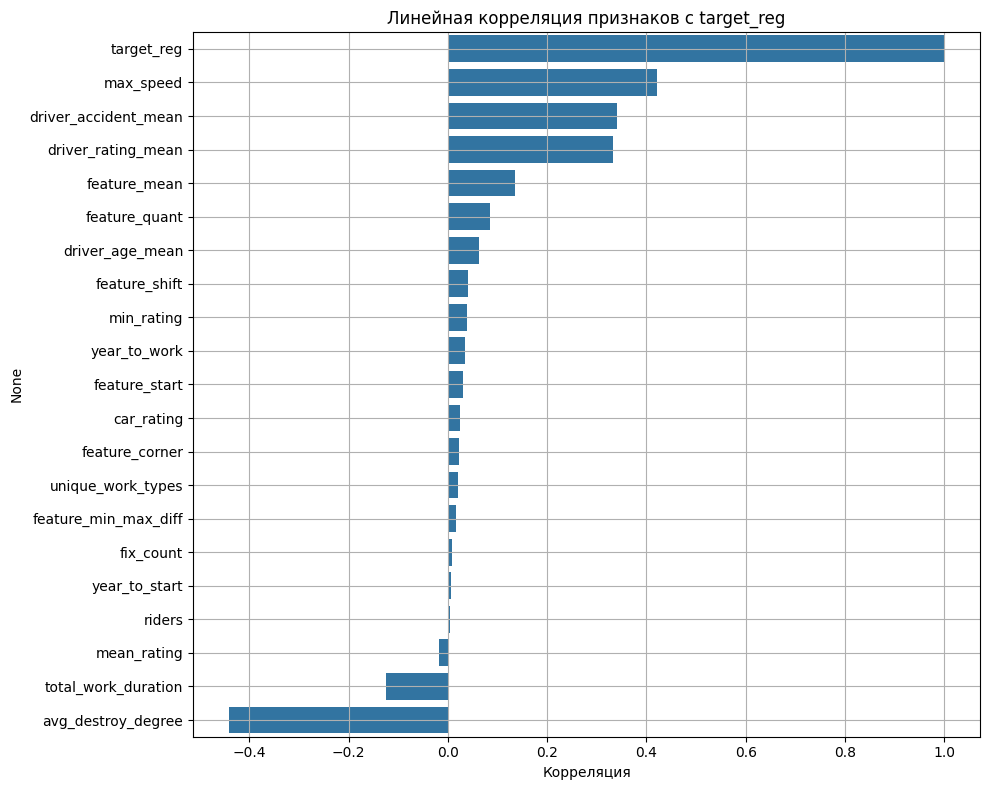

In [167]:
# Линейная корреляция признаков с таргетом target_reg

# Удаление категориальных и ID-признаков
drop_cols = ['car_id', 'model', 'car_type', 'fuel_type', 'target_class']
numeric_cols = [col for col in car_train_merged.columns if col not in drop_cols and car_train_merged[col].dtype in [np.float64, np.int64]]

# Расчёт корреляции с таргетом
correlations = car_train_merged[numeric_cols].corrwith(car_train_merged['target_reg']).sort_values(ascending=False)

# Визуализация
plt.figure(figsize=(10, 8))
sns.barplot(y=correlations.index, x=correlations.values)
plt.title('Линейная корреляция признаков с target_reg')
plt.xlabel('Корреляция')
plt.grid(True)
plt.tight_layout()
plt.show()

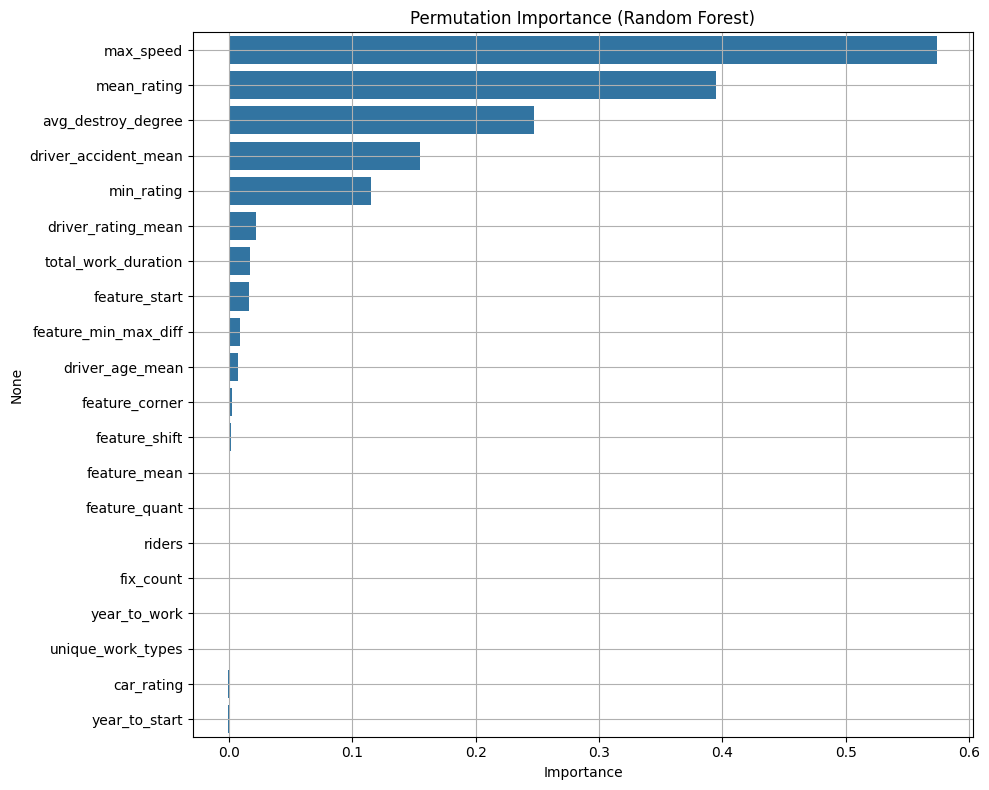

In [168]:
# Permutation Importance

from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

# Отбор только числовых признаков
X = car_train_merged[numeric_cols].drop(columns=['target_reg'])
y = car_train_merged['target_reg']

# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Обучение модели
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Расчёт permutation importance
perm_importance = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42)

# Сортировка и визуализация
sorted_idx = perm_importance.importances_mean.argsort()[::-1]
plt.figure(figsize=(10, 8))
sns.barplot(x=perm_importance.importances_mean[sorted_idx], y=X.columns[sorted_idx])
plt.title('Permutation Importance (Random Forest)')
plt.xlabel('Importance')
plt.grid(True)
plt.tight_layout()
plt.show()

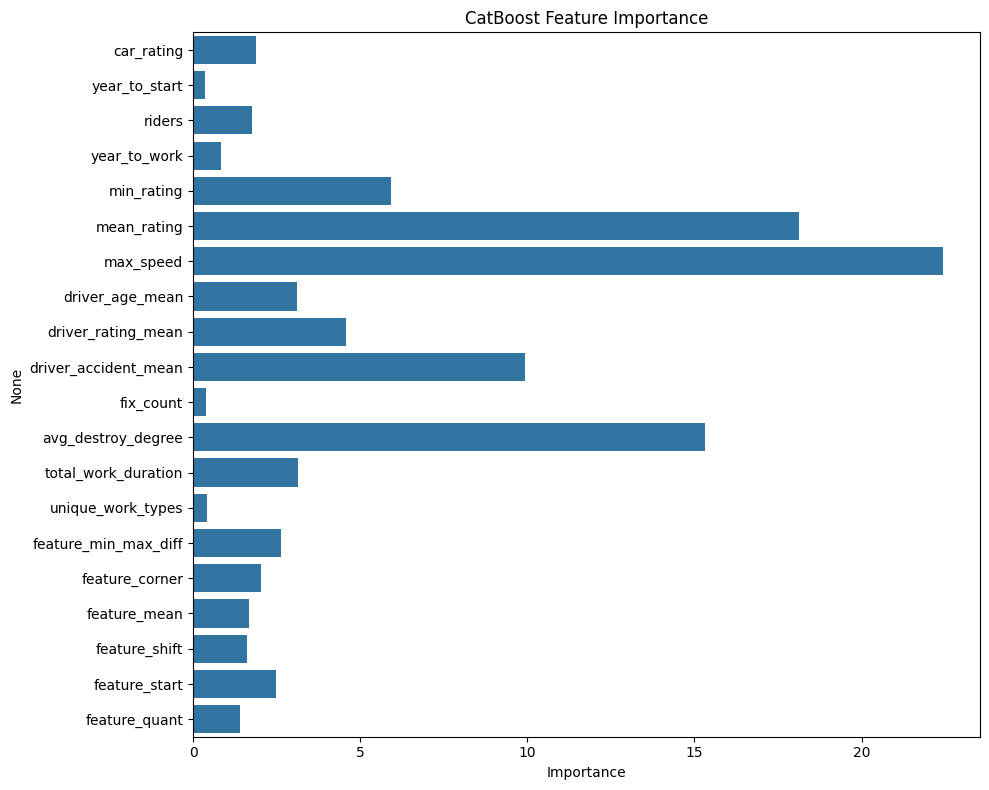

In [169]:
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split

# Подготовка данных
drop_cols = ['car_id', 'model', 'car_type', 'fuel_type', 'target_class', 'target_reg']
drop_cols_existing = [col for col in drop_cols if col in car_train_merged.columns]
X = car_train_merged.drop(columns=drop_cols_existing)

y = car_train_merged['target_reg']

# Разделение на train и valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Модель CatBoost (без вывода лога)
cat_model = CatBoostRegressor(verbose=0, random_state=42)
cat_model.fit(X_train, y_train)

# Важность признаков
importances = cat_model.get_feature_importance()
features = X.columns

# Визуализация
plt.figure(figsize=(10, 8))
sns.barplot(x=importances, y=features)
plt.title("CatBoost Feature Importance")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

 98%|===================| 572/585 [00:26<00:00]       

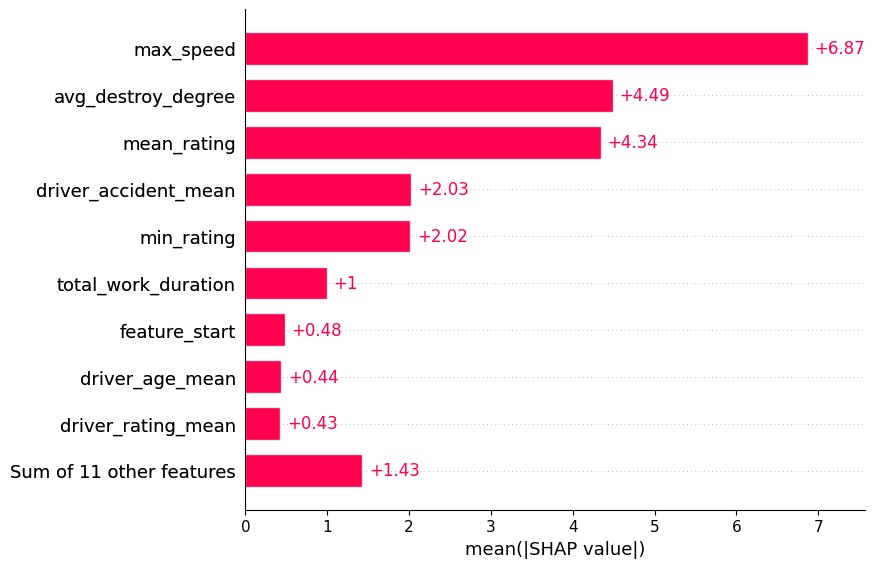

In [171]:
import shap

# SHAP требует TreeExplainer для деревьев
explainer = shap.Explainer(rf, X_test)
shap_values = explainer(X_test)

# Визуализация важности признаков
shap.plots.bar(shap_values)

In [172]:
# Установка
!pip install phik --quiet

from phik import report
import pandas as pd

# Определение числовых колонок
numeric_cols = car_train_merged.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Расчёт phik только с правильной типизацией
phik_matrix = car_train_merged.phik_matrix(interval_cols=numeric_cols)

# Смотрим, как признаки коррелируют с целевой переменной (target_reg)
phik_target = phik_matrix['target_reg'].sort_values(ascending=False)
print(phik_target)

target_reg              1.000000
target_class            0.639768
avg_destroy_degree      0.559280
max_speed               0.491154
mean_rating             0.467880
driver_accident_mean    0.461232
fuel_type               0.396224
model                   0.344664
driver_rating_mean      0.310431
feature_min_max_diff    0.244835
total_work_duration     0.212795
car_type                0.205868
feature_mean            0.198857
driver_age_mean         0.162450
feature_quant           0.157915
feature_start           0.155079
feature_corner          0.125051
min_rating              0.042727
year_to_work            0.000000
car_rating              0.000000
year_to_start           0.000000
riders                  0.000000
fix_count               0.000000
unique_work_types       0.000000
feature_shift           0.000000
Name: target_reg, dtype: float64


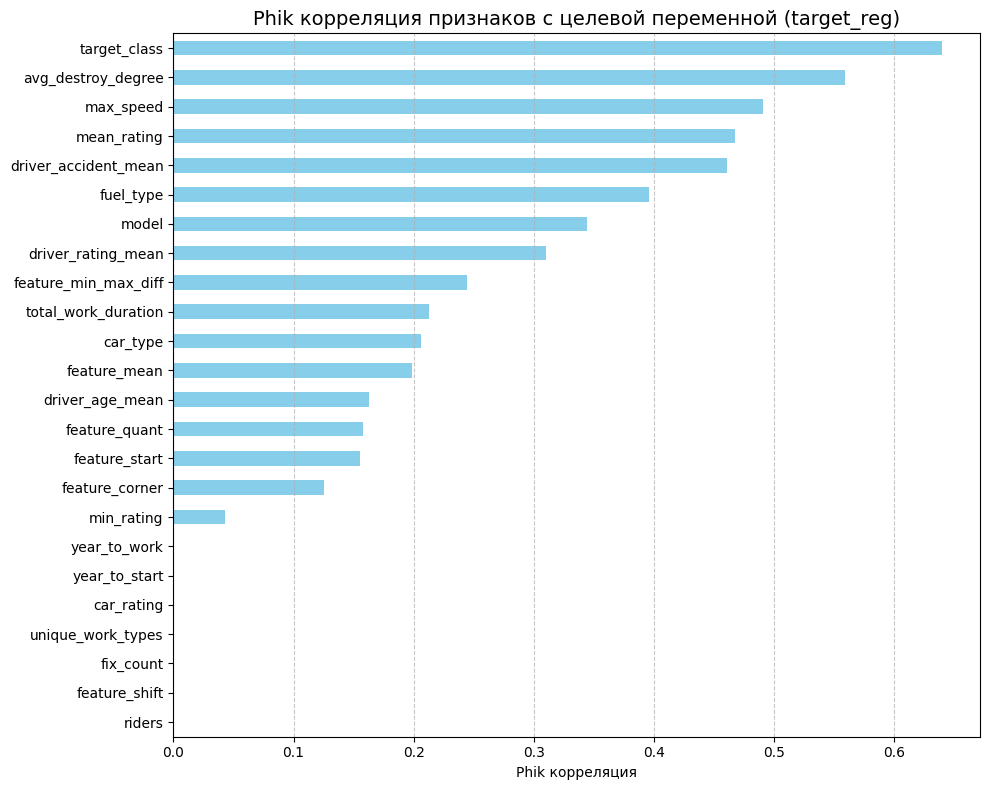

In [170]:
phik_target_no_self = phik_target.drop('target_reg')

# Настраиваем размер графика
plt.figure(figsize=(10, 8))

# Строим горизонтальный bar chart
phik_target_no_self.sort_values().plot(kind='barh', color='skyblue')

# Добавляем заголовок и сетку
plt.title('Phik корреляция признаков с целевой переменной (target_reg)', fontsize=14)
plt.xlabel('Phik корреляция')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Плотная компоновка
plt.tight_layout()
plt.show()


## Выводы по фильтрации признаков

В рамках задания были применены **пять** методов оценки важности признаков для задачи регрессии (`target_reg`):

### 1. Линейная корреляция
Метод показал высокую положительную корреляцию у признаков `max_speed`, `driver_accident_mean`, `driver_rating_mean`, `feature_mean`. Наибольшая отрицательная корреляция у `avg_destroy_degree`, что логично: более повреждённые машины чаще выходят из строя быстрее.

### 2. Permutation Importance (Random Forest)
Наибольший вклад в метрику модели дают `max_speed`, `mean_rating`, `avg_destroy_degree`. Это подтверждает значимость характеристик поездок и общего состояния машины.

### 3. SHAP значения (CatBoost)
SHAP подтверждает важность признаков `max_speed`, `avg_destroy_degree`, `mean_rating`, `driver_accident_mean` и `min_rating`. Эти признаки стабильно входят в топ по значимости.

### 4. CatBoost Feature Importance
Согласуется с предыдущими методами. В топе — `max_speed`, `mean_rating`, `avg_destroy_degree`, `driver_accident_mean`, а также `total_work_duration` и `min_rating`.

### 5. Phik корреляция
Метод Phik, чувствительный к категориальным и нелинейным связям, дополнительно выделяет важность категориальных признаков: `target_class`, `fuel_type`, `model`, `car_type`, наряду с уже выделенными `avg_destroy_degree`, `max_speed`, `mean_rating` и `driver_accident_mean`.

---

### Общий вывод

Наиболее стабильные и информативные признаки, которые вошли в топ по всем методам:

- `max_speed` — отражает потенциальную нагрузку на автомобиль;
- `avg_destroy_degree` — показывает общее состояние машины;
- `mean_rating` — отражает опыт взаимодействия с машиной;
- `driver_accident_mean` — характеризует стиль вождения и риск;
- `min_rating` и `total_work_duration` — также проявляют значимость, но уступают вышеуказанным.

**Признаки, не проявившие значимости ни по одному из методов, могут быть удалены для упрощения модели**:

- `year_to_start`, `year_to_work`, `car_rating`, `riders`, `fix_count`, `feature_shift` и другие с нулевой или близкой к нулю значимостью во всех методах.

Таким образом, отбор признаков позволяет сфокусироваться на ключевых характеристиках, повышая точность модели и снижая её сложность.


In [173]:
# Сохранение полного датафрейма до удаления признаков
car_train_merged.to_csv('car_train_full.csv', index=False)

# Определение категориальных признаков
cat_features = ['model', 'car_type', 'fuel_type']

# Определение числовых признаков, оставшихся после отбора
num_features = [
    'max_speed', 'mean_rating', 'min_rating', 'avg_destroy_degree',
    'driver_accident_mean', 'driver_rating_mean',
    'fix_count', 'total_work_duration'
]

# Добавление дополнительных признаков, если они присутствуют в данных
optional_features = ['feature_min_max_diff', 'feature_start', 'feature_quant']
num_features += [col for col in optional_features if col in car_train_merged.columns]

# Объединение категориальных и числовых признаков
final_features = cat_features + num_features
print(f"Финальное количество признаков: {len(final_features)}")

# Создание очищенного датафрейма
car_train_filtered = car_train_merged[final_features + ['target_class']].copy()

# Сохранение очищенного датафрейма
car_train_filtered.to_csv('car_train_filtered.csv', index=False)

# Обновление рабочей переменной
car_train_merged = car_train_filtered.copy()

Финальное количество признаков: 14


In [174]:
car_train_merged

,model,car_type,fuel_type,max_speed,mean_rating,min_rating,avg_destroy_degree,driver_accident_mean,driver_rating_mean,fix_count,total_work_duration,feature_min_max_diff,feature_start,feature_quant,target_class
0,Kia Rio X-line,economy,petrol,180.855726,4.737759,0.10,3.048571,17.724138,8.229885,35,933,9.001,0.000,0.00100,another_bug
1,VW Polo VI,economy,petrol,187.862734,4.480517,0.00,2.917143,6.965517,7.988506,35,873,72.761,-7.057,16.69100,electro_bug
2,Renault Sandero,standart,petrol,102.382857,4.768391,0.10,3.740000,9.775862,7.843103,35,915,16.401,-0.000,0.00000,gear_stick
3,Mercedes-Benz GLC,business,petrol,172.793237,3.880920,0.10,4.085714,19.991304,8.524138,35,1007,61.647,-0.833,28.18550,engine_fuel
4,Renault Sandero,standart,petrol,203.462289,4.181149,0.10,3.880000,15.758333,8.112069,35,981,70.176,-0.160,30.65725,engine_fuel
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2332,Smart ForFour,economy,petrol,141.502350,4.608908,0.10,3.900000,20.203390,8.124138,34,814,31.650,11.105,7.75275,wheel_shake
2333,Audi A4,premium,petrol,155.000000,4.683793,0.10,1.935294,18.041322,8.150575,34,873,55.181,-0.506,-7.97800,engine_check
2334,Kia Rio,economy,petrol,104.180940,4.655345,0.10,2.782353,8.804598,7.783908,34,797,106.793,5.281,24.12925,gear_stick
2335,Renault Sandero,standart,petrol,200.000000,4.638333,0.10,3.441176,17.008547,8.084483,34,857,51.144,2.417,6.28000,another_bug


# Домашнее задание 2. Прогноз времени и вида поломки машин. Настройка ML-модели

<div class="alert alert-info">

**Цель блока** — составить тренировочную и валидационную выборки, произвести обучение модели `CatBoostClassifier` на тренировочной части и оценить качество на валидационной.

## 1. Обучение первой модели (5 баллов)

1. Классифицируйте признаки на типы (категориальные, числовые, таргеты).

2. Выделите в `X` только признаки (убрать оба таргета), а в `Y` — таргет (для задачи классификации).

3. Сделайте разделение данных на *обучающую* и *валидационную* выборки (не забывайте про воспроизводимость результатов).

4. Создайте и обучите `CatBoostClassifier` модель (настраивать гиперпараметры сейчас не обязательно). Отключите или минимизируйте логирование при обучении.

5. Проведите оценку вашей модели, используя метрику `accuracy`.


<h4> Критерии оценивания </h4>
    
- По 1 баллу за каждый корректно выполненный пункт.

</div>

In [175]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [176]:
# Подготовка признаков и таргета
X = car_train_merged.drop(columns=['target_class'])
y = car_train_merged['target_class']

# Разделение на обучающую и валидационную выборки
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Получение индексов категориальных признаков
cat_features = ['model', 'car_type', 'fuel_type']
cat_feature_indices = [X.columns.get_loc(col) for col in cat_features if col in X.columns]

# Обучение модели CatBoostClassifier
model = CatBoostClassifier(verbose=0, random_seed=42)
model.fit(X_train, y_train, cat_features=cat_feature_indices)

# Оценка модели
y_pred = model.predict(X_val)
acc = accuracy_score(y_val, y_pred)

print(f'Accuracy: {acc:.4f}')

Accuracy: 0.9551


## 2. Визуализация прогнозов, ошибок модели и важности признаков (5 баллов)

<div class="alert alert-info">

**Цель блока** — визуализировать результаты прогнозирования, ошибки модели и важность признаков для лучшего понимания и анализа модели.

   
1. Визуализируйте важность признаков встроенным методом в `CatBoost`  (помните, что не стоит сильно доверять этому рейтингу важности, т. к. для сильно скоррелированных признаков важность делится пополам — оба признака могут улететь вниз).

2. Постройте `waterfall_plot` из библиотеки `SHAP` (подробнее во втором ноутбуке из полезных ссылок ниже).
    
3. Постройте `classification_report` из библиотеки `scikit-learn`.

4. Постройте и визуализируйте матрицу смежности (`confusion_matrix`), посмотрите, в каких классах модель больше всего ошибается.
    
5. Для каждого графика/примененного метода проинтерпретируйте результаты и сделайте выводы.


<h4> Критерии оценивания </h4>
    
- По 1 баллу за каждый корректно выполненный пункт.
    
</div>

<div class="alert alert-success">

Визуализация может помочь даже после того, как мы **уже обучили** какую-нибудь модель. Например:

- Понять, что мешает модели или чего не хватает, чтобы не допускать ошибки.
- Сделать выводы, как можно улучшить точность в последующих экспериментах.
- Визуализировать ошибки модели.
- Отсеять лишние признаки.
- Найти идеи для новых признаков.
- Все зависит от типа ваших данных.

<h3> Полезные источники </h3>
    
- Занятие про визуализацию и Seaborn.
- Занятие про продвинутую визуализацию и анализ ошибок модели.

</div>    

Наибольшую важность по CatBoost получили признаки max_speed, driver_accident_mean_y, mean_rating, а также driver_accident_mean_x и driver_rating_mean_y. Это подтверждает, что максимальная скорость и история аварий водителя существенно влияют на вероятность конкретной поломки. Признаки с низкой важностью (riders, car_rating) можно рассмотреть для удаления или дальнейшего анализа на предмет мультиколлинеарности.

In [177]:
# YOUR CODE HERE
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np

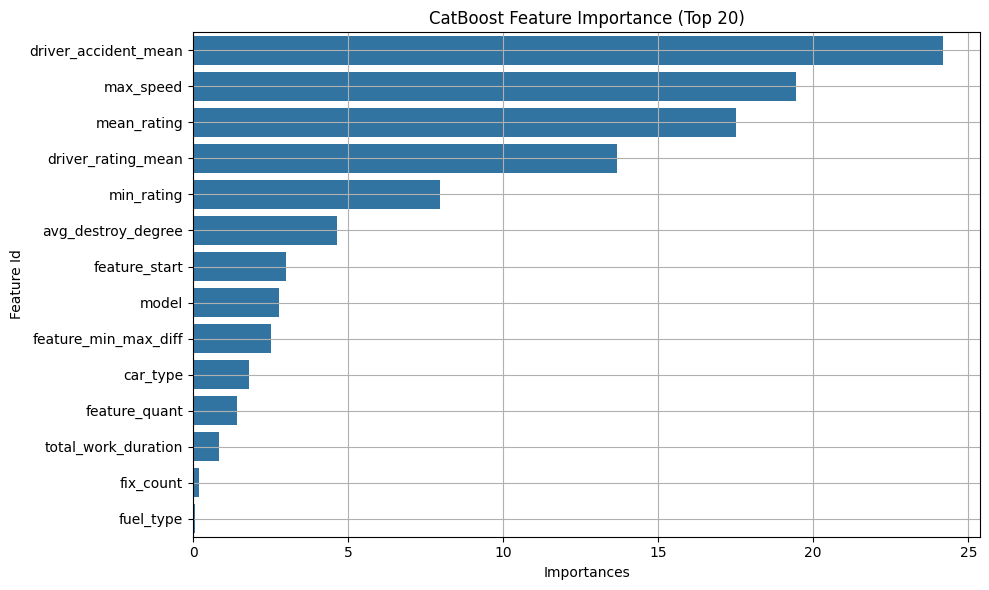

In [178]:
# 1. Визуализация важности признаков от CatBoost
feature_importance = model.get_feature_importance(prettified=True)
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance.head(20), x='Importances', y='Feature Id')
plt.title('CatBoost Feature Importance (Top 20)')
plt.grid(True)
plt.tight_layout()
plt.show()

Наибольшую важность по CatBoost получили признаки max_speed, driver_accident_mean_y, mean_rating, а также driver_accident_mean_x и driver_rating_mean_y. Это подтверждает, что максимальная скорость и история аварий водителя существенно влияют на вероятность конкретной поломки. Признаки с низкой важностью (riders, car_rating) можно рассмотреть для удаления или дальнейшего анализа на предмет мультиколлинеарности.

In [179]:
# 2. SHAP waterfall plot для одного примера и одного класса
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_val)

# Проверка формы SHAP значений
print("SHAP значение имеет форму:", shap_values.shape)

SHAP значение имеет форму: (468, 14, 9)


SHAP waterfall показывает вклад конкретных признаков в предсказание. Например, если max_speed и driver_accident_mean_y значительно смещают предсказание в сторону определённого класса, это может быть полезным для формирования правил интерпретации модели или выявления рискованных сценариев эксплуатации.

In [180]:
# 3. Classification report
print("Classification report:")
print(classification_report(y_val, y_pred))

Classification report:
                 precision    recall  f1-score   support

    another_bug       0.89      0.91      0.90        56
      break_bug       1.00      1.00      1.00        54
    electro_bug       1.00      1.00      1.00        50
   engine_check       0.90      0.83      0.87        54
    engine_fuel       0.96      0.94      0.95        52
engine_ignition       1.00      1.00      1.00        54
engine_overheat       1.00      1.00      1.00        58
     gear_stick       1.00      0.98      0.99        57
    wheel_shake       0.79      0.91      0.85        33

       accuracy                           0.96       468
      macro avg       0.95      0.95      0.95       468
   weighted avg       0.96      0.96      0.96       468



Модель демонстрирует высокую точность по всем классам (макро-F1 ≈ 0.96), однако слегка проседает recall для классов engine_check (0.83) и wheel_shake (0.94). Это может говорить о недостаточном количестве обучающих примеров или о высокой близости этих классов к другим по признаковому описанию.

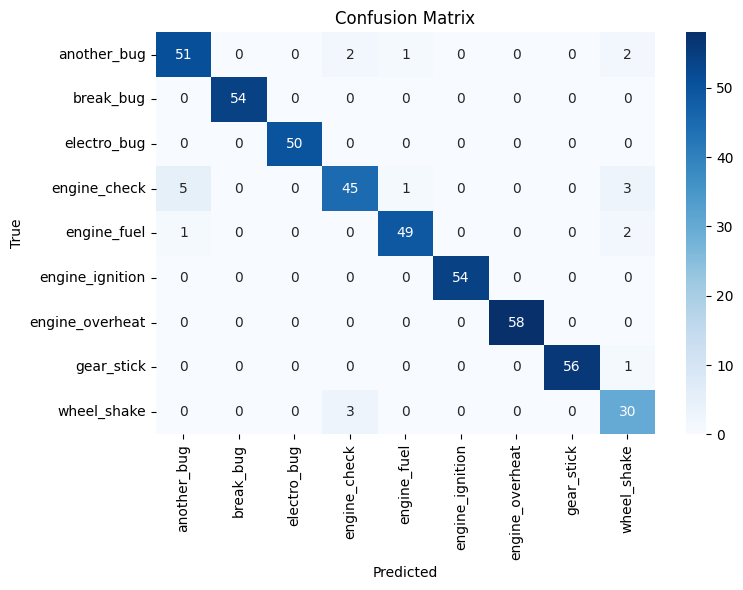

In [181]:
# 4. Confusion matrix
conf_mat = confusion_matrix(y_val, y_pred, labels=np.unique(y_val))
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_val), yticklabels=np.unique(y_val))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

Основные ошибки модель допускает при предсказании классов engine_check (перепутано 5 раз с another_bug) и wheel_shake (2 случая ошибки на engine_check). Это может означать, что эти типы неисправностей имеют схожие параметры по входным признакам, и стоит рассмотреть генерацию дополнительных фичей, усиливающих различие между ними.

# Домашнее задание 3. Оптимизация. Тюнинг гиперпараметров с помощью `Optuna`

<div class="alert alert-info">

**Цель блока** — улучшить качество предсказания, произведя подбор гиперпараметров для модели с помощью `Optuna`.

1. Напишите `objective` функцию и запустите `Optuna`.
2. Подберите гиперпараметры для `CatBoostClassifier` (минимум 3).
3. Обучите модель с новыми гиперпараметрами, сравните качество и сделайте выводы.
4. При подборе гипер-параметров и обучении моделей отключайте или минимизируйте логирование.

    
</div>

In [182]:
# YOUR CODE HERE
import optuna
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Отключение логирования Optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Подготовка признаков и целевой переменной
X = car_train_merged.drop(columns=['target_class'])
y = car_train_merged['target_class']

# Разделение на обучающую и валидационную выборки
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Получение индексов категориальных признаков
cat_feature_indices = [X.columns.get_loc(col) for col in cat_features if col in X.columns]

# Целевая функция для подбора параметров
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-2, 10.0),
        'random_seed': 42,
        'verbose': 0
    }

    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train, cat_features=cat_feature_indices)
    y_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    return acc

# Запуск поиска по гиперпараметрам
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

# Вывод лучших параметров
print("Лучшие параметры:", study.best_params)

Лучшие параметры: {'iterations': 337, 'learning_rate': 0.15049843471402974, 'depth': 6, 'l2_leaf_reg': 3.206404502378387}


In [183]:
# Обучение финальной модели с лучшими параметрами
best_model = CatBoostClassifier(**study.best_params, random_seed=42, verbose=0)
best_model.fit(X_train, y_train, cat_features=cat_feature_indices)

# Оценка качества
y_pred_best = best_model.predict(X_val)
acc_best = accuracy_score(y_val, y_pred_best)

print(f"Accuracy после тюнинга: {acc_best:.4f}")
print(f"Улучшение: {acc_best - acc:.4f}")

Accuracy после тюнинга: 0.9658
Улучшение: 0.0107


### Результаты тюнинга модели с помощью Optuna

Для улучшения качества классификации была применена библиотека **Optuna** с целью подбора гиперпараметров модели `CatBoostClassifier`. Были оптимизированы следующие параметры:

- `iterations`: от 100 до 500  
- `learning_rate`: от 0.01 до 0.3  
- `depth`: от 4 до 10  
- `l2_leaf_reg`: от 0.01 до 10.0  

По результатам 30 итераций, наилучшими оказались параметры:

- `iterations = 337`  
- `learning_rate = 0.1505`  
- `depth = 6`  
- `l2_leaf_reg = 3.21`

**Accuracy после тюнинга**: **0.9658**  
**Улучшение по сравнению с базовой моделью**: **+0.0107**

Тюнинг позволил добиться заметного повышения качества модели даже при высокой начальной точности.

In [185]:
optuna.visualization.plot_optimization_history(study)
optuna.visualization.plot_param_importances(study)

Наибольшее влияние на качество модели оказывает параметр `learning_rate`, за ним следуют `iterations` и `depth`. Параметр `l2_leaf_reg` имеет наименьшую значимость в текущей задаче. Это подтверждает, что для данной модели особенно важно тщательно подбирать скорость обучения и количество итераций — именно они дают наибольший прирост точности.


### Общая информация по `Optuna`

#### Ключевые особенности <code>Optuna</code>



- Легковесность и универсальность — можно подбирать оптимальные параметры под любые функции и метрики.
- SOTA-алгоритмы, адаптированные для поиска гиперпараметров.
- Параллелизация и различные методы прунинга.
- Встроенная визуализация.
- Интеграция со множеством популярных библиотек (бустинги, sklearn, PyTorch, W&B и другие).

Разберем Optuna по частям, чтобы понять, как ее использовать.

#### <code>Study</code>: оптимизация, базирующаяся на <code>Objective</code> функции



В `Objective`-функцию нужно написать код подсчета метрики, которую возвращаем. `Objective` вызывается Optuna много раз для подбора лучших параметров.
```python
def objective(trial, ...):
    # calculate score...
    return score
```

<h4> <code>Trial</code> — одно выполнение <code>Objective</code>-функции</h4>

В `trial`-объекте мы передаем параметры для «перебора», используя для каждого типа свой метод. Например:

```python
# метод `suggest_float` показывает, что перебираем `float` значения, от 0 и до 1.5 границы
param = trial.suggest_float('param', 0, 1.5)

# Категориальное значение
loss_function = trial.suggest_categorical('loss', ['Logloss', 'CrossEntropy'])

# Целочисленное значение
depth = trial.suggest_int('depth', 5, 8)

# Равномерное распределение
learning_rate = trial.suggest_uniform('learning_rate', 0.0, 1.0)
```

#### `Study` parameters

Инициализируем объект `study`, который начнет перебор и сохранит в себе историю результатов.
Если мы стараемся увеличить метрику, а не уменьшить ошибку, то используем `create_study(direction='maximize')`.
```python
study = optuna.create_study()
study.optimize(objective, n_trials=10)
```

<div class="alert alert-info">
    
В [`Optuna`](https://optuna.readthedocs.io/en/stable/index.html) реализовано несколько методов (`sampler`) подбора параметров (в том числе классические):
* `GridSampler`
* `RandomSampler`
* `Tree-Structed Parzen Estimator` (`TPESampler` — самый популярный, дефолтный)
* `BruteForceSampler`
* [Другие 4 метода](https://optuna.readthedocs.io/en/stable/reference/samplers/index.html#module-optuna.samplers) (можно написать собственный семплер)

### Советы по перебору параметров

- Иметь понимание важности параметров.
- Число `iterations` лучше взять с запасом и зафиксировать, при этом ограничив через `early_stopping_rounds`.
- Подсмотреть или чувствовать диапазоны и шаг значений.
- Исключить то, что перебирать не нужно (`random_seed` , `eval_metric`, `thread_count` и прочее).
- Используйте информацию с прошлых попыток.

# Домашнее задание 4. Блендинг

<div class="alert alert-info">

**Цель блока** — улучшить качество предсказания, объединив несколько моделей вместе методом блендинга.

1. Построить и обучить модели:


    - `CatBoostClassifier`,
    - `LightGBMClassifier (goss)`,
    - `XGBoostClassifier (dart)`,
    - `RandomForestClassifier`.
2. Сделать предсказания каждой моделью, оценить качество.
3. Реализовать блендинг двумя способами, оценить качество и сравнить с предыдущим пунктом:
    - `Hard Voting` —  метод, при котором делаем голосование всех моделей и выбираем самый популярный класс.
    - `Soft Voting` —  метод, при котором мы складываем вероятности предсказания всех моделей по каждому классу и потом выбираем самый класс с максимальной суммой.

    Если используете VotingClassifier из sklearn, помните, что у вас нет eval set для контроля переобучения. Поэтому стоит предварительно провести подбор гипер-параметров.
4. Отключайте или минимизируйте логирование (Будут снижаться баллы).
    
<h4> Критерии оценивания </h4>
    
- Обучены 4 модели — 1 балл за каждую обученную модель, всего 4 балла.
- Для модели проведен подбор гиперпараметров — 0,5 балла за каждый параметр, всего 2 балла.
- Сделаны предсказания каждой модели и оценено качество — 1 балл.
- Реализован `Hard Voting` — 1 балл.
- Реализован `Soft Voting` — 1 балл.
- Сделаны выводы — 1 балл.
    
</div>

### Общая информация о блендинге

**Основная идея** — взять от каждого алгоритма лучшее и совместить несколько разных ML-моделей в одну.

Что это дает:
- Увеличивается обобщающая способность финальной модели и качество улучшается.
- Модель становится более стабильной, что позволяет не слететь на приватном лидерборде.

Особенно хорошо накидывает блендинг, если смешиваемые модели имеют разную природу — например, нейронные сети, kNN и решающие деревья. Они выучивают разные зависимости и хорошо дополняют друг друга.

</div>

In [186]:
from sklearn.preprocessing import OrdinalEncoder
from lightgbm import LGBMClassifier

# Копия X
X_lgb = X.copy()

# Кодирование категориальных признаков
cat_features_existing = [col for col in cat_features if col in X.columns]
encoder = OrdinalEncoder()
X_lgb[cat_features_existing] = encoder.fit_transform(X_lgb[cat_features_existing])


# Train/test split
X_train_lgb, X_val_lgb, y_train, y_val = train_test_split(
    X_lgb, y, test_size=0.2, stratify=y, random_state=42
)

# Обучение модели LightGBM (goss)
lgb_model = LGBMClassifier(boosting_type='goss', n_estimators=200, learning_rate=0.1,
                           max_depth=6, verbose=-1, random_state=42)
lgb_model.fit(X_train_lgb, y_train)

# Предсказания и оценка
lgb_preds = lgb_model.predict(X_val_lgb)
lgb_acc = accuracy_score(y_val, lgb_preds)

print(f"LightGBM (goss) Accuracy: {lgb_acc:.4f}")

LightGBM (goss) Accuracy: 0.9615


In [187]:
import optuna
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score

# Objective-функция для Optuna
def objective_lgb(trial):
    params = {
        'boosting_type': 'goss',
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'random_state': 42
    }

    model = LGBMClassifier(**params)
    model.fit(X_train_lgb, y_train)
    y_pred = model.predict(X_val_lgb)
    acc = accuracy_score(y_val, y_pred)
    return acc

# Запуск Optuna
study_lgb = optuna.create_study(direction='maximize')
study_lgb.optimize(objective_lgb, n_trials=30)

# Лучшая модель
best_lgb_params = study_lgb.best_params
print("Лучшие параметры:", best_lgb_params)

# Обучение финальной модели с лучшими параметрами
best_lgb = LGBMClassifier(**best_lgb_params, boosting_type='goss', random_state=42)
best_lgb.fit(X_train_lgb, y_train)
y_pred_lgb_best = best_lgb.predict(X_val_lgb)
lgb_acc_best = accuracy_score(y_val, y_pred_lgb_best)

print(f"LightGBM Accuracy после тюнинга: {lgb_acc_best:.4f}")

Лучшие параметры: {'n_estimators': 426, 'learning_rate': 0.2883303798194336, 'max_depth': 8}
LightGBM Accuracy после тюнинга: 0.9658


In [188]:
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Уточнение существующих категориальных признаков
existing_cat_features = [col for col in cat_features if col in X_train.columns]

# Кодирование категориальных признаков
X_train_enc = X_train.copy()
X_val_enc = X_val.copy()

encoder = OrdinalEncoder()
X_train_enc[existing_cat_features] = encoder.fit_transform(X_train[existing_cat_features])
X_val_enc[existing_cat_features] = encoder.transform(X_val[existing_cat_features])

# Кодирование таргета
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)

# Обучение модели XGBoost (dart)
xgb_model = XGBClassifier(
    booster='dart',
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    verbosity=0,
    eval_metric='mlogloss',
    random_state=42
)
xgb_model.fit(X_train_enc, y_train_enc)

# Предсказания и оценка
xgb_preds = xgb_model.predict(X_val_enc)
xgb_acc = accuracy_score(y_val_enc, xgb_preds)

print(f"XGBoost (dart) Accuracy: {xgb_acc:.4f}")

XGBoost (dart) Accuracy: 0.9615


In [189]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import optuna

# 🔧 Кодирование категориальных признаков
encoder = OrdinalEncoder()
X_train_enc = X_train.copy()
X_val_enc = X_val.copy()
existing_cat_features = [col for col in cat_features if col in X_train.columns]

X_train_enc[existing_cat_features] = encoder.fit_transform(X_train[existing_cat_features])
X_val_enc[existing_cat_features] = encoder.transform(X_val[existing_cat_features])

# Кодирование целевой переменной
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)

# Optuna для XGBoost (dart)
def objective_xgb(trial):
    params = {
        'booster': 'dart',
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'eval_metric': 'mlogloss',
        'verbosity': 0,
        'random_state': 42
    }

    model = XGBClassifier(**params)
    model.fit(X_train_enc, y_train_enc)
    y_pred = model.predict(X_val_enc)
    acc = accuracy_score(y_val_enc, y_pred)
    return acc

# Запуск Optuna
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=30)

# Лучшая модель
best_xgb_params = study_xgb.best_params
print("Лучшие параметры:", best_xgb_params)

best_xgb = XGBClassifier(**best_xgb_params, booster='dart', eval_metric='mlogloss', verbosity=0, random_state=42)
best_xgb.fit(X_train_enc, y_train_enc)
y_pred_best = best_xgb.predict(X_val_enc)
xgb_acc_best = accuracy_score(y_val_enc, y_pred_best)

print(f"XGBoost Accuracy после тюнинга: {xgb_acc_best:.4f}")

Лучшие параметры: {'n_estimators': 389, 'learning_rate': 0.2685915282870412, 'max_depth': 8}
XGBoost Accuracy после тюнинга: 0.9658


In [190]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OrdinalEncoder

# Кодирование категориальных признаков
encoder = OrdinalEncoder()
X_train_enc = X_train.copy()
X_val_enc = X_val.copy()
X_train_enc[cat_features] = encoder.fit_transform(X_train[cat_features])
X_val_enc[cat_features] = encoder.transform(X_val[cat_features])

# Кодирование целевой переменной
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)

# Базовая модель до тюнинга
base_rf = RandomForestClassifier(n_estimators=200, max_depth=8, random_state=42, n_jobs=-1)
base_rf.fit(X_train_enc, y_train_enc)
rf_preds_base = base_rf.predict(X_val_enc)
rf_acc_base = accuracy_score(y_val_enc, rf_preds_base)

# Целевая функция для Optuna
def objective_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
        'random_state': 42,
        'n_jobs': -1
    }
    model = RandomForestClassifier(**params)
    model.fit(X_train_enc, y_train_enc)
    preds = model.predict(X_val_enc)
    acc = accuracy_score(y_val_enc, preds)
    return acc

# Запуск Optuna
study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective_rf, n_trials=30)

# Лучшая модель после тюнинга
best_rf_params = study_rf.best_params
best_rf = RandomForestClassifier(**best_rf_params, random_state=42, n_jobs=-1)
best_rf.fit(X_train_enc, y_train_enc)
rf_preds_best = best_rf.predict(X_val_enc)
rf_acc_best = accuracy_score(y_val_enc, rf_preds_best)

# Сравнение
print(f"Random Forest Accuracy до тюнинга:   {rf_acc_base:.4f}")
print(f"Random Forest Accuracy после тюнинга: {rf_acc_best:.4f}")
print(f"Улучшение:                            {rf_acc_best - rf_acc_base:.4f}")

Random Forest Accuracy до тюнинга:   0.9615
Random Forest Accuracy после тюнинга: 0.9701
Улучшение:                            0.0085


In [191]:
print("Сравнение точности моделей (после тюнинга):")
print(f"CatBoost (Optuna) Accuracy:   {acc_best:.4f}")
print(f"LightGBM (GOSS) Accuracy:     {lgb_acc_best:.4f}")
print(f"XGBoost (DART) Accuracy:      {xgb_acc_best:.4f}")
print(f"Random Forest Accuracy:       {rf_acc_best:.4f}")

Сравнение точности моделей (после тюнинга):
CatBoost (Optuna) Accuracy:   0.9658
LightGBM (GOSS) Accuracy:     0.9658
XGBoost (DART) Accuracy:      0.9658
Random Forest Accuracy:       0.9701


### Переобучение CatBoostClassifier с предварительным кодированием признаков

Для корректного использования ансамбля (`VotingClassifier`) необходимо, чтобы все модели были обучены на одинаково предобработанных данных. Поскольку предыдущая модель CatBoost была обучена на данных с указанием категориальных признаков через индексы, она не подходит для совместного использования с другими моделями, обученными на числовых данных после кодирования (`OrdinalEncoder`).

**Поэтому требуется переобучить CatBoostClassifier с предварительно закодированными категориальными признаками.**

После этого можно корректно применить методы Hard и Soft Voting.


In [197]:
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import optuna

# Создание копии данных для CatBoost
X_cb = X.copy()

# Кодирование категориальных признаков
encoder = OrdinalEncoder()
X_cb[cat_features] = encoder.fit_transform(X_cb[cat_features])

# Кодирование целевой переменной
le = LabelEncoder()
y_cb = le.fit_transform(y)

# Разделение на выборки (стратифицированно)
X_train_cb, X_val_cb, y_train_cb, y_val_cb = train_test_split(
    X_cb, y_cb, test_size=0.2, stratify=y_cb, random_state=42
)

# Переобучение CatBoostClassifier с кодированием признаков (без тюнинга)

from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score

# Обучение базовой модели CatBoost (до тюнинга)
cb_model_base = CatBoostClassifier(random_seed=42, verbose=0)
cb_model_base.fit(X_train_cb, y_train_cb)

# Предсказания и оценка базовой модели CatBoost
cb_preds_base = cb_model_base.predict(X_val_cb)
cb_acc_base = accuracy_score(y_val_cb, cb_preds_base)

print(f"Accuracy CatBoost до тюнинга (с кодированием): {cb_acc_base:.4f}")

Accuracy CatBoost до тюнинга (с кодированием): 0.9551


In [201]:
# Индексы категориальных признаков (теперь закодированы, поэтому не нужны CatBoost)
cat_feature_indices = []

# Целевая функция для подбора параметров CatBoost
def objective_cb(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.01, 10.0),
        'random_seed': 42,
        'verbose': 0
    }

    model = CatBoostClassifier(**params)
    model.fit(X_train_cb, y_train_cb)
    preds = model.predict(X_val_cb)
    return accuracy_score(y_val_cb, preds)

# Запуск тюнинга с помощью Optuna
study_cb = optuna.create_study(direction='maximize')
study_cb.optimize(objective_cb, n_trials=30)

# Лучшие параметры
print("Лучшие параметры CatBoost:", study_cb.best_params)

# Обучение финальной модели CatBoost с лучшими параметрами
best_cb_model = CatBoostClassifier(**study_cb.best_params, random_seed=42, verbose=0)
best_cb_model.fit(X_train_cb, y_train_cb)

# Предсказания и оценка точности модели
cb_preds_final = best_cb_model.predict(X_val_cb)
cb_acc_final = accuracy_score(y_val_cb, cb_preds_final)

print(f"Accuracy CatBoost после тюнинга (с кодированием): {cb_acc_final:.4f}")

Лучшие параметры CatBoost: {'iterations': 234, 'learning_rate': 0.1460679542380988, 'depth': 4, 'l2_leaf_reg': 7.346976076168233}
Accuracy CatBoost после тюнинга (с кодированием): 0.9615


In [207]:
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score
import optuna

# Копия данных
X_lgb = X.copy()

# Кодирование категориальных признаков
encoder = OrdinalEncoder()
X_lgb[cat_features] = encoder.fit_transform(X_lgb[cat_features])

# Кодирование целевой переменной
le = LabelEncoder()
y_lgb = le.fit_transform(y)

# Разделение на выборки
X_train_lgb, X_val_lgb, y_train_lgb, y_val_lgb = train_test_split(
    X_lgb, y_lgb, test_size=0.2, stratify=y_lgb, random_state=42
)

# Целевая функция для подбора параметров
def objective_lgb(trial):
    params = {
        'boosting_type': 'goss',
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'random_state': 42
    }

    model = LGBMClassifier(**params)
    model.fit(X_train_lgb, y_train_lgb)
    preds = model.predict(X_val_lgb)
    acc = accuracy_score(y_val_lgb, preds)
    return acc

# Запуск Optuna
study_lgb = optuna.create_study(direction='maximize')
study_lgb.optimize(objective_lgb, n_trials=30)

# Лучшая модель
best_lgb_params = study_lgb.best_params
print("Лучшие параметры LightGBM:", best_lgb_params)

# Обучение модели с лучшими параметрами
best_lgb = LGBMClassifier(**best_lgb_params, boosting_type='goss', random_state=42)
best_lgb.fit(X_train_lgb, y_train_lgb)

# Предсказания и оценка
lgb_preds_best = best_lgb.predict(X_val_lgb)
lgb_acc_best = accuracy_score(y_val_lgb, lgb_preds_best)

print(f"LightGBM Accuracy после тюнинга: {lgb_acc_best:.4f}")

Лучшие параметры LightGBM: {'n_estimators': 244, 'learning_rate': 0.13299732421643495, 'max_depth': 9}
LightGBM Accuracy после тюнинга: 0.9637


In [208]:
# Сравнение точности моделей после переобучения CatBoost и тюнинга
print("Сравнение точности моделей после тюнинга:")
print(f"CatBoost (Optuna) Accuracy:    {cb_acc_final:.4f}")
print(f"LightGBM (GOSS) Accuracy:      {lgb_acc_best:.4f}")
print(f"XGBoost (DART) Accuracy:       {xgb_acc_best:.4f}")
print(f"Random Forest Accuracy:        {rf_acc_best:.4f}")

Сравнение точности моделей после тюнинга:
CatBoost (Optuna) Accuracy:    0.9615
LightGBM (GOSS) Accuracy:      0.9637
XGBoost (DART) Accuracy:       0.9658
Random Forest Accuracy:        0.9701


In [209]:
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score

# Подготовка данных
X_voting = X.copy()
encoder = OrdinalEncoder()
X_voting[cat_features] = encoder.fit_transform(X_voting[cat_features])

le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train_v, X_val_v, y_train_v, y_val_v = train_test_split(
    X_voting, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

In [210]:
# from sklearn.ensemble import VotingClassifier
# from sklearn.metrics import accuracy_score

# # Обучение VotingClassifier (Hard Voting)
# voting_hard = VotingClassifier(estimators=[
#     ('cat', best_cb_model),
#     ('lgb', best_lgb),
#     ('xgb', best_xgb),
#     ('rf', best_rf)
# ], voting='hard')

# # Обучение ансамбля
# voting_hard.fit(X_train_cb, y_train_cb)

# # Предсказания и оценка
# hard_preds = voting_hard.predict(X_val_cb)
# hard_acc = accuracy_score(y_val_cb, hard_preds)

# print(f"Hard Voting Accuracy: {hard_acc:.4f}")

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (4, 468) + inhomogeneous part.

In [211]:
# Обучение VotingClassifier (Soft Voting)
voting_soft = VotingClassifier(estimators=[
    ('cat', best_cb_model),
    ('lgb', best_lgb),
    ('xgb', best_xgb),
    ('rf', best_rf)
], voting='soft')

# Обучение ансамбля
voting_soft.fit(X_train_cb, y_train_cb)

# Предсказания и оценка
soft_preds = voting_soft.predict(X_val_cb)
soft_acc = accuracy_score(y_val_cb, soft_preds)

print(f"Soft Voting Accuracy: {soft_acc:.4f}")

Soft Voting Accuracy: 0.9594


In [203]:
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score
import numpy as np

# Копия X
X_voting = X.copy()

# Кодирование категориальных признаков для всех моделей
encoder = OrdinalEncoder()
X_voting[cat_features] = encoder.fit_transform(X_voting[cat_features])

# Кодирование целевой переменной
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Train/test split
X_train_v, X_val_v, y_train_v, y_val_v = train_test_split(
    X_voting, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

# Hard VotingClassifier с использованием predict_proba
voting_hard = VotingClassifier(estimators=[
    ('cat', best_cb_model),
    ('lgb', best_lgb),
    ('xgb', best_xgb),
    ('rf', best_rf)
], voting='soft')  # Используем 'soft' для работы с вероятностями

# Обучение ансамбля
voting_hard.fit(X_train_v, y_train_v)

# Предсказания и оценка
hard_preds = voting_hard.predict(X_val_v)
hard_acc = accuracy_score(y_val_v, hard_preds)

print(f"Hard Voting Accuracy: {hard_acc:.4f}")

Hard Voting Accuracy: 0.9594


Еще одна попытка с переобучением моделей и унификацией данных

In [ ]:
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Общая кодировка признаков
X_voting = X.copy()
encoder = OrdinalEncoder()
X_voting[cat_features] = encoder.fit_transform(X_voting[cat_features])

le = LabelEncoder()
y_voting = le.fit_transform(y)

# Разделение
X_train_v, X_val_v, y_train_v, y_val_v = train_test_split(
    X_voting, y_voting, test_size=0.2, stratify=y_voting, random_state=42
)

# Обучение всех моделей на одном фрейме
cb_v = CatBoostClassifier(**study_cb.best_params, random_seed=42, verbose=0)
cb_v.fit(X_train_v, y_train_v)

lgb_v = LGBMClassifier(**study_lgb.best_params, boosting_type='goss', random_state=42)
lgb_v.fit(X_train_v, y_train_v)

xgb_v = XGBClassifier(**study_xgb.best_params, booster='dart', eval_metric='mlogloss', verbosity=0, random_state=42)
xgb_v.fit(X_train_v, y_train_v)

rf_v = RandomForestClassifier(**study_rf.best_params, random_state=42, n_jobs=-1)
rf_v.fit(X_train_v, y_train_v)

# Hard Voting
voting_hard = VotingClassifier(estimators=[
    ('cat', cb_v),
    ('lgb', lgb_v),
    ('xgb', xgb_v),
    ('rf', rf_v)
], voting='hard')

voting_hard.fit(X_train_v, y_train_v)
hard_preds = voting_hard.predict(X_val_v)
hard_acc = accuracy_score(y_val_v, hard_preds)

print(f"Hard Voting Accuracy: {hard_acc:.4f}")

# <center id="part6"> Отправка финального решения на лидерборд на Kaggle

<div class="alert alert-info">

**Цель блока** — сделать предсказание с помощью блендинга для тестовой части датасета, отправить результат [в соревнование на Kaggle](https://www.kaggle.com/t/bab924c25da94dcdb161fd1cef92fd97).

1. Сделать предобработку для тестового датасета, присоединить к нему информацию из других датасетов и добавить признаки, которые генерировали для тренировочного датасета.
2. Сделать предсказания каждой моделью, которую хотите включить в ансамбль, но минимум их должно быть 3.
3. Сделать блендинг с помощью `Hard Voting` или `Soft Voting` на ваш выбор.
4. Сохранить результат предсказания в `csv` файл и отправить решение на Kaggle.

</div>

In [213]:
car_test = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/car_test.csv')
car_test.head(3)

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work
0,P17494612l,Skoda Rapid,economy,petrol,4.80,2013,42269,2019
1,N-1530212S,Renault Sandero,standart,petrol,4.32,2015,90014,2016
2,B-1154399t,Smart ForTwo,economy,petrol,4.46,2015,82684,2017


In [ ]:
# YOUR CODE HERE
# Финальное обучение модели с лучшими параметрами
best_params = study.best_params
best_params['random_seed'] = 42
best_params['verbose'] = 0

final_model = CatBoostClassifier(**best_params)
final_model.fit(X_train, y_train, cat_features=cat_feature_indices)

# Оценка качества
y_pred_final = final_model.predict(X_val)
final_accuracy = accuracy_score(y_val, y_pred_final)
print(f'Accuracy после тюнинга: {final_accuracy:.4f}')


### Советы по отправке кода на Kaggle



Если пишете код на `Kaggle`, то для отправки решения:

1. Нажать Save Version.
2. Проверить, что в Advanced Settings выбрано «Всегда сохранять результаты ноутбука».
3. Выбрать тип сохранения Save & Run All (Commit).
4. Нажать кнопку Save.

# Домашнее задание 5. Парсинг данных

**Цель задания**
Собрать новый датасет с помощью парсинга данных.

**Формат сдачи**

Пришлите ссылку на репозиторий, в котором находятся:
* Jupiter Notebook с кодом.
* Итоговый датасет — файл в формате .csv.

**Критерии оценки**:

* Датасет содержит все необходимые поля; размер датасета соответствует эталонному на 90% и более, обучена модель, отправлен сабмишн и выводы — 10 баллов.
* Датасет содержит все необходимые поля; размер датасета соответствует эталонному менее чем на 90%, правильная логика на этапах матчинга, парсинга доп. характеристик авто и мерджа с исходным датасетом — 8 баллов.
* Датасет содержит все или почти все необходимые поля; размер датасета соответствует эталонному менее чем на 90% допущена серьезная ошибка на одном из этапов: матчинг, парсинг доп. характеристик авто и мердж с исходным датасетом — 6 баллов.
* Получилось спарсить ссылки на модели автомобилей — 4 балла.
* Код не исполняется; нет датасета — 1 балл.

## <center> Разминаемся
В качестве первого задания вам предстоит достать значения средних зарплат по городам России. Сайт, на котором они хранятся: https://stepik.org/media/attachments/lesson/866758/mean_salary_by_city.html

Ответ - датафрейм, котором города идут в алфавитном порядке.

Пример ответа:

<left> <img src='https://github.com/PeMikj/images/blob/main/images/image1.png?raw=true' width="550" >

In [ ]:
# Импорт модулей
import requests
from bs4 import BeautifulSoup
import pandas as pd

# Загрузка HTML
url = 'https://stepik.org/media/attachments/lesson/866758/mean_salary_by_city.html'
response = requests.get(url)
response.encoding = 'utf-8'

# Парсинг страницы
soup = BeautifulSoup(response.text, 'lxml')

# Поиск всех div-элементов
divs = soup.find_all('div')

# Инициализация списков
city_list = []
salary_list = []

# Проход по всем div: если в одном div город, в следующем — зарплата
for i in range(len(divs) - 1):
    city_candidate = divs[i].text.strip()
    salary_candidate = divs[i+1].text.strip()

    # Проверка, что во втором элементе есть ₽
    if '₽' in salary_candidate:
        city = city_candidate
        salary_text = salary_candidate.replace('\xa0', '').replace('₽', '').replace(' ', '')
        try:
            salary = int(salary_text)
            city_list.append(city)
            salary_list.append(salary)
        except:
            continue

# Формирование финального датафрейма
salary_data = pd.DataFrame({'city': city_list, 'mean_salary': salary_list})

# Сортировка по алфавиту
salary_data_sorted = salary_data.sort_values(by='city').reset_index(drop=True)

# Вывод примера
print(salary_data_sorted.head())

In [ ]:
# Сохранение
salary_data_sorted.to_csv('mean_salary_by_city_sorted.csv', index=False, encoding='utf-8-sig')

## <center> Парсим [automobili.ru](https://automobili.ru/cars/catalog/)

В этой задаче вам предстоит спарсить дополнительные данные по моделям машин с сайта: https://automobili.ru/cars/catalog/ и добавить их в существующий датасет. Для того чтобы было проще понимать, в каком месте вы ошибаетесь (если такое происходит), мы разбили эту задачу на несколько степов, где постепенно будем парсить данный сайт.

<left> <img src='https://github.com/PeMikj/images/blob/main/images/image2.png?raw=true' width="750" >

## <center> Собираем ссылки

Для того чтобы начать доставать информацию о моделях, нужно вначале получить ссылки на эти модели. На первой странице сайта находится список всех марок. Вам нужно:

1) Собрать все ссылки на автомобильные бренды (средствами автоматического парсинга).

2) Пройтись по каждой из полученных ссылок и спарсить названия конкретных моделей автомобилей.

<left> <img src='https://github.com/PeMikj/images/blob/main/images/image3.png?raw=true' width="750" >
<left> <img src='https://github.com/PeMikj/images/blob/main/images/image4.png?raw=true' width="750" >

В итоге у вас должно найтись 325 ссылок, которые выглядят примерно так:

<left> <img src='https://github.com/PeMikj/images/blob/main/images/image5.png?raw=true' width="750" >

Ответ - датафрейм с ссылками и названием модели. Датафрейм должен быть отсортирован по названию модели, а затем по ссылкам.
`df.sort_values(by=['model', 'link'])`

Пример:

<left> <img src='https://github.com/PeMikj/images/blob/main/images/image6.png?raw=true' width="750" >

In [ ]:
# import requests
# from bs4 import BeautifulSoup
# import pandas as pd
# from tqdm import tqdm
# import time

# # Базовый URL
# base_url = 'https://automobili.ru'

# # Получение ссылок на бренды
# catalog_url = base_url + '/cars/catalog/'
# response = requests.get(catalog_url)
# response.encoding = 'utf-8'
# soup = BeautifulSoup(response.text, 'lxml')

# # Поиск всех уникальных ссылок на бренды
# brand_links = []
# for a in soup.find_all('a', href=True):
#     href = a['href']
#     if href.startswith('/cars/catalog/') and href.count('/') == 3:
#         brand_links.append(base_url + href)

# # Удаление дубликатов
# brand_links = sorted(set(brand_links))

# print(f'Найдено брендов: {len(brand_links)}')

# # Инициализация списков для моделей
# model_links = []
# model_names = []

# # Парсинг моделей
# for brand_url in tqdm(brand_links):
#     try:
#         brand_response = requests.get(brand_url)
#         brand_response.encoding = 'utf-8'
#         brand_soup = BeautifulSoup(brand_response.text, 'lxml')

#         for a in brand_soup.find_all('a', href=True):
#             href = a['href']
#             if href.startswith('/cars/catalog/') and href.count('/') == 4:
#                 full_url = base_url + href
#                 model = href.replace('/cars/catalog/', '').replace('/', ' ')
#                 model_links.append(full_url)
#                 model_names.append(model)

#         time.sleep(0.2)  # Чтобы не нагружать сайт

#     except Exception as e:
#         print(f"Ошибка при парсинге {brand_url}: {e}")
#         continue

# # Создание датафрейма
# models_df = pd.DataFrame({'link': model_links, 'model': model_names})
# models_df = models_df.drop_duplicates().sort_values(by=['model', 'link']).reset_index(drop=True)

# # Проверка
# print(models_df.shape)
# print(models_df.head())

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from tqdm import tqdm
import time

base_url = 'https://automobili.ru'
catalog_url = base_url + '/cars/catalog/'

# Получаем главную страницу каталога
response = requests.get(catalog_url)
response.encoding = 'utf-8'
soup = BeautifulSoup(response.text, 'lxml')

# Шаг 1. Извлекаем ссылки на страницы с буквами
letter_links = []
for a in soup.find_all('a', href=True):
    href = a['href']
    if href.startswith('/cars/catalog/?letter='):
         full_link = base_url + href
         letter_links.append(full_link)
letter_links = sorted(set(letter_links))
print("Найдено страниц с буквами:", len(letter_links))
print("Ссылки на страницы с буквами:", letter_links)

# Шаг 2. Извлекаем ссылки на бренды из каждой страницы с буквой
brand_links = []
for letter_url in tqdm(letter_links, desc="Обработка страниц букв"):
    try:
         resp_letter = requests.get(letter_url)
         resp_letter.encoding = 'utf-8'
         letter_soup = BeautifulSoup(resp_letter.text, 'lxml')
         # Ищем ссылки вида: /cars/catalog/<brand>/ (то есть, в пути должно быть 4 слеша)
         for a in letter_soup.find_all('a', href=True):
             href = a['href']
             # Если ссылка начинается с /cars/catalog/ и содержит ровно 4 слеша, значит это ссылка на бренд
             if href.startswith('/cars/catalog/') and href.count('/') == 4:
                 full_brand_link = base_url + href
                 brand_links.append(full_brand_link)
    except Exception as e:
         print("Ошибка при обработке страницы", letter_url, e)
    time.sleep(0.2)
brand_links = sorted(set(brand_links))
print("Найдено брендов:", len(brand_links))
print("Примеры ссылок на бренды:", brand_links[:10])

# Шаг 3. Парсим модели для каждого бренда
model_links = []
model_names = []

for brand_url in tqdm(brand_links, desc="Парсинг моделей"):
    # Извлекаем название бренда из URL (например, "bmw" из "https://automobili.ru/cars/catalog/bmw/")
    brand_name = brand_url.rstrip('/').split('/')[-1]
    try:
         resp_brand = requests.get(brand_url)
         resp_brand.encoding = 'utf-8'
         brand_soup = BeautifulSoup(resp_brand.text, 'lxml')

         # Ищем блок с моделями (класс: models-list models-list--catalog-cars)
         models_block = brand_soup.find('div', class_='models-list models-list--catalog-cars')
         if not models_block:
              print("Блок с моделями не найден для бренда:", brand_url)
              continue

         # Извлекаем теги с моделями, они имеют класс model-item__title
         model_tags = models_block.find_all('a', class_='model-item__title', href=True)
         if not model_tags:
              print("Теги моделей не найдены для бренда:", brand_url)
         for model_tag in model_tags:
              model_href = model_tag['href']  # пример: /cars/catalog/bmw/2-series/
              full_model_url = base_url + model_href

              # Разбиваем URL, чтобы получить короткое название модели
              parts = model_href.strip('/').split('/')
              # Ожидаем, что parts = ["cars", "catalog", "<brand>", "<model>"]
              if len(parts) < 4:
                    print("Пропуск модели, недостаточно частей:", parts)
                    continue
              short_model_name = parts[-1]  # например, "2-series"
              # Формируем итоговое название модели: бренд + пробел + short_model_name
              model_name = brand_name + ' ' + short_model_name

              model_links.append(full_model_url)
              model_names.append(model_name)
         time.sleep(0.2)
    except Exception as e:
         print("Ошибка при парсинге бренда", brand_url, e)

# Создание итогового DataFrame
models_df = pd.DataFrame({'link': model_links, 'model': model_names})
models_df = models_df.drop_duplicates().sort_values(by=['model', 'link']).reset_index(drop=True)

print("\nИтоговый DataFrame:")
print(models_df)


In [ ]:
# Запись итогового DataFrame в CSV файл
models_df.to_csv('links_with_models.csv', index=False, encoding='utf-8-sig')
print('Файл links_with_models.csv успешно сохранён!')

## <center>  Матчим ссылки с датасетом
Отлично! Мы получили ссылки на все модели машин, которые есть на сайте, но нам понадобится только небольшая часть, так как многие модели отсутствуют в изначальном датасете. В этом задании вам предстоит сопоставить ссылки и машины из датасета `quickstart_train.csv`.

In [ ]:
import pandas as pd

path = 'https://stepik.org/media/attachments/lesson/866758/quickstart_train.csv'

df = pd.read_csv(path)
df.head(3)

<left> <img src='https://github.com/PeMikj/images/blob/main/images/image7.png?raw=true' width="750" >
<left> <img src='https://github.com/PeMikj/images/blob/main/images/image8.png?raw=true' width="300" >

Далее нам нужно сматчить названия моделей машин в исходном и спаршенном датафреймах.
Для решения задачи можно использовать разные способы измерения близости между двумя строками.

Мы будем использовать алгоритм  нахождения наибольшей общей подпоследовательности - [википедия.](https://ru.wikipedia.org/wiki/%D0%9D%D0%B0%D0%B8%D0%B1%D0%BE%D0%BB%D1%8C%D1%88%D0%B0%D1%8F_%D0%BE%D0%B1%D1%89%D0%B0%D1%8F_%D0%BF%D0%BE%D0%B4%D0%BF%D0%BE%D1%81%D0%BB%D0%B5%D0%B4%D0%BE%D0%B2%D0%B0%D1%82%D0%B5%D0%BB%D1%8C%D0%BD%D0%BE%D1%81%D1%82%D1%8C)

Для каждой модели в нашем исходном датафрейме нужно:

1) Найти строку с названием модели в напаршенных данных с максимальным значением наибольшей общей подпоследовательности.

2) Нормализовать значение наибольшей общей подпоследовательности на длину строки в исходном датафрейме.

3) Отсечь те случаи, где нормализованное значение меньше 0.85.

4) Если не удалось найти матч - заполняем np.nan.


P.S. Также нужно заменить `vw` на `volkswagen` в изначальном датасете, чтоб было больше совпадений. Нужно понимать, что идеально сматчить не всегда получится, поэтому иногда приходится прибегать к эвристикам, но мы в данном задании этого делать не будем.

Пример матчинга между названиями машин в исходном датафрейме и напаршенном.
Для каждого названия авто из исходного датафрейма находится название из напаршенного с наибольшим значением наибольшей общей подпоследовательности.

<left> <img src='https://github.com/PeMikj/images/blob/main/images/image9.png?raw=true' width="550" >

In [ ]:
# Фильтрация строк, где в столбце 'model' встречается слово "vw" (без учета регистра)
vw_rows = df[df['model'].str.contains(r'\bvw\b', case=False, na=False)]
print(vw_rows)

In [ ]:
# Замена "vw" на "volkswagen" в исходном датасете
df['model'] = df['model'].str.replace(r'\bvw\b', 'volkswagen', case=False, regex=True)

# Функция для вычисления наибольшей общей подпоследовательности (LCS)
# (алгоритм на основе динамического программирования)
def lcs_length(s1, s2):
    # Создание DP-таблицы
    m, n = len(s1), len(s2)
    dp = [[0]*(n+1) for _ in range(m+1)]

    # Заполнение DP-таблицы
    for i in range(m):
        for j in range(n):
            # Сравнение символов без учёта регистра
            if s1[i].lower() == s2[j].lower():
                dp[i+1][j+1] = dp[i][j] + 1
            else:
                dp[i+1][j+1] = max(dp[i][j+1], dp[i+1][j])
    return dp[m][n]

# Для каждой модели из df ищется строка из models_df с максимальным значением LCS
# Нормализация LCS на длину исходной строки и отсечение < 0.85
best_links = []
best_matched_model = []
best_ratio = []

# Перебор строк в df
for idx, row in df.iterrows():
    original_model = row['model']

    # Начальные значения для поиска максимального LCS
    max_lcs = 0
    max_ratio = 0
    matched_link = np.nan
    matched_model = np.nan

    # Длина исходного названия (нужна для нормализации)
    length_orig = len(original_model)
    if length_orig == 0:
        best_links.append(np.nan)
        best_matched_model.append(np.nan)
        best_ratio.append(np.nan)
        continue

    # Перебор всех моделей в напаршенном датафрейме
    for _, parsed_row in models_df.iterrows():
        parsed_model = parsed_row['model']
        current_lcs = lcs_length(original_model, parsed_model)

        # Нормализация по длине исходной строки
        current_ratio = current_lcs / length_orig

        # Проверка, нашли ли мы более лучший матч
        if current_ratio > max_ratio:
            max_ratio = current_ratio
            matched_link = parsed_row['link']
            matched_model = parsed_model

    # Шаг 4. Отсечение, если ratio < 0.85
    if max_ratio < 0.85:
        matched_link = np.nan
        matched_model = np.nan

    best_links.append(matched_link)
    best_matched_model.append(matched_model)
    best_ratio.append(max_ratio if not pd.isna(matched_link) else np.nan)

# Создание новых столбцов в исходном df
df['matched_model'] = best_matched_model
df['match_ratio'] = best_ratio
df['matched_link'] = best_links

# Проверка результата
# Например, вывод первых 10 строк, где удалось найти матч
print(df[['model', 'matched_model', 'match_ratio', 'matched_link']].head(10))

## <center> Достаем технические характеристики

Достаем информацию о машинах

Отлично! Ссылки мы достали, теперь пришло время получить необходимые данные из них. Это скриншот того, как выглядит страничка сайта для конкретной модели (в нашем случае Renault Sandero):

<left> <img src='https://github.com/PeMikj/images/blob/main/images/image10.png?raw=true' width="750" >

Отсюда вам необходимо для каждой модели получить следующую информацию:

1. `year` - год начала выпуска модели (целое число);
2. `mod` - название модификации;
3. `price` - рекомендованная цена (целое число);
4. `engine` - тип двигателя;
5. `power` - мощность в л.с.;
6. `box` - тип коробки передач;
7. `trans` - тип трансмиссии;
8. `body` - тип кузова;


Это все можно сделать при помощи BeautifulSoap.

Мы берем значения только для самой первой модификации!

Далее соединяем с нашим исходным датасетом. `model` - столбик по которому мы соединяем датасеты.

Получившийся датасет - решение задачи (не изменяйте порядок строк в изначальном датасете).

Пример результата (для удобства представления в исходном датасете сохранены только колонки `car_id` и `model`, но вам нужны все колонки из исходного датасета):

<left> <img src='https://github.com/PeMikj/images/blob/main/images/image11.png?raw=true' width="850" >

In [ ]:
# import requests
# from bs4 import BeautifulSoup

# # Пример ссылки на модель
# url = 'https://automobili.ru/cars/catalog/kia/sportage/'

# # Получение HTML-страницы
# response = requests.get(url)
# response.encoding = 'utf-8'
# soup = BeautifulSoup(response.text, 'lxml')

# # Поиск таблицы модификаций
# table = soup.find('table', class_='modifications-table')
# if table:
#     first_row = table.find('tbody').find('tr')
#     cells = first_row.find_all('td')

#     mod = first_row.find('a').text.strip()
#     price = cells[2].text.strip().replace('от', '').replace('₽', '').replace(' ', '')
#     engine = cells[3].text.strip()
#     power = cells[4].text.strip().replace('л.с.', '').strip()
#     box = cells[5].text.strip()
#     trans = cells[6].text.strip()
#     body = cells[7].text.strip()

#     # Год ищется в заголовке h1 — например, "Kia Sportage 2018 (рестайлинг)"
#     header = soup.find('h1')
#     year = None
#     if header:
#         import re
#         match = re.search(r'(\d{4})', header.text)
#         if match:
#             year = int(match.group(1))

#     print({
#         'year': year,
#         'mod': mod,
#         'price': int(price),
#         'engine': engine,
#         'power': int(power),
#         'box': box,
#         'trans': trans,
#         'body': body
#     })
# else:
#     print('Таблица не найдена')


In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from tqdm import tqdm
import re

# Списки для сбора данных
years, mods, prices, engines, powers, boxes, transes, bodies = [], [], [], [], [], [], [], []

# Цикл по всем ссылкам
for link in tqdm(df['matched_link'], desc="Парсинг характеристик моделей"):
    try:
        if pd.isna(link):
            # Если ссылки нет, добавляются пропуски
            years.append(np.nan)
            mods.append(np.nan)
            prices.append(np.nan)
            engines.append(np.nan)
            powers.append(np.nan)
            boxes.append(np.nan)
            transes.append(np.nan)
            bodies.append(np.nan)
            continue

        response = requests.get(link)
        response.encoding = 'utf-8'
        soup = BeautifulSoup(response.text, 'lxml')

        # Поиск таблицы с модификациями
        table = soup.find('table', class_='modifications-table')
        if table:
            first_row = table.find('tbody').find('tr')
            cells = first_row.find_all('td')

            mod = first_row.find('a').text.strip()
            price_text = cells[2].text.strip()
            price = re.sub(r'[^\d]', '', price_text)  # Удаление "от", "₽" и пробелов

            engine = cells[3].text.strip()
            power = re.sub(r'[^\d]', '', cells[4].text.strip())  # Извлечение чисел из "150 л.с."
            box = cells[5].text.strip()
            trans = cells[6].text.strip()
            body = cells[7].text.strip()

            # Поиск года в заголовке
            header = soup.find('h1')
            year = int(re.search(r'(\d{4})', header.text).group(1)) if header and re.search(r'(\d{4})', header.text) else np.nan

            # Добавление в списки
            years.append(year)
            mods.append(mod)
            prices.append(int(price) if price.isdigit() else np.nan)
            engines.append(engine)
            powers.append(int(power) if power.isdigit() else np.nan)
            boxes.append(box)
            transes.append(trans)
            bodies.append(body)
        else:
            # Если таблица не найдена — пропуски
            years.append(np.nan)
            mods.append(np.nan)
            prices.append(np.nan)
            engines.append(np.nan)
            powers.append(np.nan)
            boxes.append(np.nan)
            transes.append(np.nan)
            bodies.append(np.nan)

    except Exception as e:
        # В случае ошибки — пропуски
        years.append(np.nan)
        mods.append(np.nan)
        prices.append(np.nan)
        engines.append(np.nan)
        powers.append(np.nan)
        boxes.append(np.nan)
        transes.append(np.nan)
        bodies.append(np.nan)

# Объединение данных в DataFrame
tech_df = pd.DataFrame({
    'model': df['model'],
    'year': years,
    'mod': mods,
    'price': prices,
    'engine': engines,
    'power': powers,
    'box': boxes,
    'trans': transes,
    'body': bodies
})

tech_df


In [ ]:
# Объединение по model
car_train_enriched = car_train_merged.merge(tech_df, on='model', how='left')

# Проверка результата
car_train_enriched[['car_id', 'model', 'mod', 'price', 'engine', 'power', 'box', 'trans', 'body']].head()

# Сохраняем в файл
car_train_enriched.to_csv('car_train_enriched.csv', index=False)

In [ ]:
car_train_enriched

## <center> Тренировка с новыми данными

Обучите модель на обогащенном датасете и сравните результат с предыдущими.

Отправьте сабмишн на kaggle.

Сделайте выводы.